In [194]:
import os

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import date
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#그래프를 주피터 화면에 띄워주는 기능을 함
%matplotlib inline
#plt.show없이 바로 그래프 생성 가능

# 필요한 패키지와 라이브러리를 가져옴
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager, rc
from matplotlib import style

import geopy.distance

import seaborn as sns
import random
import pandas_profiling

import math

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',999)

In [2]:
import datetime

In [3]:
def preprocessor_train(df,df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14):
    
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday
    df = pd.get_dummies(df,columns=['weekday'])
    df['in_out'] = df['in_out'].map({'시내':0,'시외':1})
    
    a=df1.groupby(['geton_station_code'])['bus_route_id'].unique().reset_index()

    list2=[]
    for i in a['bus_route_id']:
        p=len(i)
        list2.append(p)
    
    a['노선수']=list2
    a.drop(columns=['bus_route_id'],inplace=True)
    
    df= pd.merge(df,a,left_on='station_code',right_on='geton_station_code',how='left')

    a=df1.groupby(['getoff_station_code'])['bus_route_id'].unique().reset_index()

    list2=[]
    for i in a['bus_route_id']:
        p=len(i)
        list2.append(p)
    
    a['노선수1']=list2
    a.drop(columns=['bus_route_id'],inplace=True)
        
    df= pd.merge(df,a,left_on='station_code',right_on='getoff_station_code',how='left')

    list1=[]
    for i,j in zip(df['노선수'],df['노선수1']):
        if i >=j:
            list1.append(i)
        elif i< j:
            list1.append(j)
        elif math.isnan(i):
            list1.append(j)
        elif math.isnan(j):
            list1.append(i)
            
    df['노선수3']=list1
    df.drop(columns=['노선수1','노선수'])
    
    coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
    coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
    df['dis_jejusi'] = [geopy.distance.vincenty((df['latitude'].iloc[i],df['longitude'].iloc[i]), coords_jejusi).km for i in range(len(df))]
    df['dis_seoquipo'] = [geopy.distance.vincenty((df['latitude'].iloc[i],df['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(df))]
    
    dis = pd.DataFrame({"dis_jejusi":df['dis_jejusi'],"dis_seoquipo":df['dis_seoquipo']}) 
    dis['dis'] = dis.min(axis = 1)
    dis['id'] = df['id']
    del dis['dis_jejusi']
    del dis['dis_seoquipo']
    df = pd.merge(df, dis ,on='id', how = 'left')
    
    
    df1['geton_time']=df1['geton_time'].str[0:2]
    # 버스 노선별 버스 수 -> 많을수록 많은 사람들이 타기 때문??... df
    df1['geton_date'] = pd.to_datetime(df1['geton_date'])
    df1['weekday'] = df1['geton_date'].dt.weekday
    df_bus=df1.groupby(['bus_route_id','geton_date','geton_time'])['vhc_id'].nunique().to_frame('vhc_id').reset_index()
    
    df_bus1 = df_bus.pivot_table('vhc_id', ['bus_route_id','geton_date'], 'geton_time')
    df_bus1.reset_index(inplace=True)
    df_bus1.rename(columns={'geton_date':'date'},inplace=True)
    
    df_bus1['date'] = pd.to_datetime(df_bus1['date'])
    train1=pd.merge(df,df_bus1,on=['bus_route_id','date'],how='left')
    
    df_people=df1.groupby(['bus_route_id','geton_date','geton_station_code','user_category'])['user_count'].mean().to_frame('user_count').reset_index()
    df_people1 = df_people.pivot_table('user_count', ['bus_route_id','geton_date','geton_station_code'], 'user_category')
    df_people1.reset_index(inplace=True)
    df_people1.rename(columns={1:'일반',2:'어린이',4:'청소년',6:'경로',27:'장애_일반',28:'장애_동반',29:'유공_일반',30:'유공_동반'},inplace=True)
    
    df_people1['geton_date'] = pd.to_datetime(df_people1['geton_date'])
    df_people1.rename(columns={'geton_date':'date'},inplace=True)
    df_people1.rename(columns={'geton_station_code':'station_code'},inplace=True)
    train2=pd.merge(train1,df_people1,on=['bus_route_id','date','station_code'],how='left')
    train2
    
    train2['오전 하차수']=train2['6~7_takeoff']+train2['7~8_takeoff']+train2['8~9_takeoff']+train2['9~10_takeoff']+train2['10~11_takeoff']+train2['11~12_takeoff']
    train2['오전 승차수']=train2['6~7_ride']+train2['7~8_ride']+train2['8~9_ride']+train2['9~10_ride']+train2['10~11_ride']+train2['11~12_ride']
    
    split = df2['동'].str.split(' ')
    split = split.apply(lambda x: pd.Series(x))
    split[4]=split[3]+ ' ' +split[1]
    df2['시동']=split[4]
    del df2['Unnamed: 0']
    del df2['동']
    df2.rename(columns={'0':'좌표'},inplace=True)
    train2['좌표']=train2['latitude'].astype(str)+','+train2['longitude'].astype(str)
    train3=pd.merge(train2,df2,on='좌표',how='left')
    
    holiday=['2019-09-01','2019-09-07','2019-09-08','2019-09-12','2019-09-13','2019-09-14','2019-09-15','2019-09-21','2019-09-22',
         '2019-09-28','2019-09-29']

    list1=[]
    for i in train3['date'].astype(str):
        if i in holiday:
            list1.append(1)
        else:
            list1.append(0)
        
        
    train3['휴일여부']=list1
    
    train3.rename(columns={'시동':'동'},inplace=True)
    
    pd_con1=pd.concat([df3,df4]).reset_index().drop(columns=['index'])
    pd_con1.rename(columns={'날짜':'date'},inplace=True)
    pd_con1['date']= pd.to_datetime(pd_con1['date'])
    train31=pd.merge(train3,pd_con1,on=['동','date'],how='left')
    
    pd_con2=pd.concat([df6,df7]).reset_index().drop(columns=['index'])
    pd_con2.rename(columns={'날짜':'date'},inplace=True)
    pd_con2['date']= pd.to_datetime(pd_con2['date'])
    train32=pd.merge(train31,pd_con2,on=['동','date'],how='left',suffixes=('_강수여부','_습도'))
    
    pd_con3=pd.concat([df8,df9]).reset_index().drop(columns=['index'])
    pd_con3.rename(columns={'날짜':'date'},inplace=True)
    pd_con3['date']= pd.to_datetime(pd_con3['date'])
    train33=pd.merge(train32,pd_con3,on=['동','date'],how='left')
    
    pd_con4=pd.concat([df10,df11]).reset_index().drop(columns=['index'])
    pd_con4.rename(columns={'날짜':'date'},inplace=True)
    pd_con4['date']= pd.to_datetime(pd_con4['date'])
    train34=pd.merge(train33,pd_con4,on=['동','date'],how='left',suffixes=('_풍향','_풍속'))
    
    pd_con5=pd.concat([df12,df13]).reset_index().drop(columns=['index'])
    pd_con5.rename(columns={'날짜':'date'},inplace=True)
    pd_con5['date']= pd.to_datetime(pd_con5['date'])
    train4=pd.merge(train34,pd_con5,on=['동','date'],how='left')
    
    
    
    train4['10~11_ride_nearest_sum']=df5['10~11_ride_nearest_sum']
    train4['10~11_takeoff_nearest_sum']=df5['10~11_takeoff_nearest_sum']
    train4['8~9_ride_nearest_sum']=df5['8~9_ride_nearest_sum']
    train4['8~9_takeoff_nearest_sum']=df5['8~9_takeoff_nearest_sum']
    train4['6~7_ride_nearest_sum']=df5['6~7_ride_nearest_sum']
    train4['6~7_takeoff_nearest_sum']=df5['6~7_takeoff_nearest_sum']
    train4['7~8_takeoff_nearest_sum']=df5['7~8_takeoff_nearest_sum']
    train4['7~8_ride_nearest_sum']=df5['7~8_ride_nearest_sum']
    train4['9~10_takeoff_nearest_sum']=df5['9~10_takeoff_nearest_sum']
    train4['9~10_takeoff_nearest_sum']=df5['9~10_takeoff_nearest_sum']
    
    
    train4['10~12_ride_nearest_sum']=df5['10~11_ride_nearest_sum']+df5['11~12_ride_nearest_sum']
    train4['10~12_takeoff_nearest_sum']=df5['10~11_takeoff_nearest_sum']+df5['11~12_takeoff_nearest_sum']
    train4['8~10_ride_nearest_sum']=df5['8~9_ride_nearest_sum']+df5['9~10_ride_nearest_sum']
    train4['8~10_takeoff_nearest_sum']=df5['8~9_takeoff_nearest_sum']+df5['9~10_takeoff_nearest_sum']
    train4['6~8_ride_nearest_sum']=df5['6~7_ride_nearest_sum']+df5['7~8_ride_nearest_sum']
    train4['6~8_takeoff_nearest_sum']=df5['6~7_takeoff_nearest_sum']+df5['7~8_takeoff_nearest_sum']
    
    
    
    a=train4.groupby(['동'])['station_code'].unique().reset_index()

    list2=[]
    for i in a['station_code']:
        p=len(i)
        list2.append(p)
    
    a['개수']=list2
    a.drop(columns=['station_code'],inplace=True)
    
    train5= pd.merge(train4,a,on='동',how='left')
    
    train5=pd.merge(train5,df14,on='id',how='left')
    
    
    return train5
    

In [4]:
def preprocessor_test(df,df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14):
    df['date'] = pd.to_datetime(df['date'])
    df['weekday'] = df['date'].dt.weekday
    df = pd.get_dummies(df,columns=['weekday'])
    df['in_out'] = df['in_out'].map({'시내':0,'시외':1})
    
    a=df1.groupby(['geton_station_code'])['bus_route_id'].unique().reset_index()

    list2=[]
    for i in a['bus_route_id']:
        p=len(i)
        list2.append(p)
    
    a['노선수']=list2
    a.drop(columns=['bus_route_id'],inplace=True)
    
    df= pd.merge(df,a,left_on='station_code',right_on='geton_station_code',how='left')

    a=df1.groupby(['getoff_station_code'])['bus_route_id'].unique().reset_index()

    list2=[]
    for i in a['bus_route_id']:
        p=len(i)
        list2.append(p)
    
    a['노선수1']=list2
    a.drop(columns=['bus_route_id'],inplace=True)
        
    df= pd.merge(df,a,left_on='station_code',right_on='getoff_station_code',how='left')

    list1=[]
    for i,j in zip(df['노선수'],df['노선수1']):
        if i >=j:
            list1.append(i)
        elif i< j:
            list1.append(j)
        elif math.isnan(i):
            list1.append(j)
        elif math.isnan(j):
            list1.append(i)
            
    df['노선수3']=list1
    df.drop(columns=['노선수1','노선수'])
    
    coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
    coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도
    df['dis_jejusi'] = [geopy.distance.vincenty((df['latitude'].iloc[i],df['longitude'].iloc[i]), coords_jejusi).km for i in range(len(df))]
    df['dis_seoquipo'] = [geopy.distance.vincenty((df['latitude'].iloc[i],df['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(df))]
    
    dis = pd.DataFrame({"dis_jejusi":df['dis_jejusi'],"dis_seoquipo":df['dis_seoquipo']}) 
    dis['dis'] = dis.min(axis = 1)
    dis['id'] = df['id']
    del dis['dis_jejusi']
    del dis['dis_seoquipo']
    df = pd.merge(df, dis ,on='id', how = 'left')
    
    
    df1['geton_time']=df1['geton_time'].str[0:2]
    # 버스 노선별 버스 수 -> 많을수록 많은 사람들이 타기 때문??... df
    df1['geton_date'] = pd.to_datetime(df1['geton_date'])
    df1['weekday'] = df1['geton_date'].dt.weekday
    df_bus=df1.groupby(['bus_route_id','geton_date','geton_time'])['vhc_id'].nunique().to_frame('vhc_id').reset_index()
    
    df_bus1 = df_bus.pivot_table('vhc_id', ['bus_route_id','geton_date'], 'geton_time')
    df_bus1.reset_index(inplace=True)
    df_bus1.rename(columns={'geton_date':'date'},inplace=True)
    
    df_bus1['date'] = pd.to_datetime(df_bus1['date'])
    train1=pd.merge(df,df_bus1,on=['bus_route_id','date'],how='left')
    
    df_people=df1.groupby(['bus_route_id','geton_date','geton_station_code','user_category'])['user_count'].mean().to_frame('user_count').reset_index()
    df_people1 = df_people.pivot_table('user_count', ['bus_route_id','geton_date','geton_station_code'], 'user_category')
    df_people1.reset_index(inplace=True)
    df_people1.rename(columns={1:'일반',2:'어린이',4:'청소년',6:'경로',27:'장애_일반',28:'장애_동반',29:'유공_일반',30:'유공_동반'},inplace=True)
    
    df_people1['geton_date'] = pd.to_datetime(df_people1['geton_date'])
    df_people1.rename(columns={'geton_date':'date'},inplace=True)
    df_people1.rename(columns={'geton_station_code':'station_code'},inplace=True)
    train2=pd.merge(train1,df_people1,on=['bus_route_id','date','station_code'],how='left')
    train2
    
    train2['오전 하차수']=train2['6~7_takeoff']+train2['7~8_takeoff']+train2['8~9_takeoff']+train2['9~10_takeoff']+train2['10~11_takeoff']+train2['11~12_takeoff']
    train2['오전 승차수']=train2['6~7_ride']+train2['7~8_ride']+train2['8~9_ride']+train2['9~10_ride']+train2['10~11_ride']+train2['11~12_ride']
    
    split = df2['동'].str.split(' ')
    split = split.apply(lambda x: pd.Series(x))
    split[4]=split[3]+ ' ' +split[1]
    df2['시동']=split[4]
    del df2['Unnamed: 0']
    del df2['동']
    df2.rename(columns={'0':'좌표'},inplace=True)
    train2['좌표']=train2['latitude'].astype(str)+','+train2['longitude'].astype(str)
    train3=pd.merge(train2,df2,on='좌표',how='left')

    
    holiday=['2019-10-03','2019-10-05','2019-10-06','2019-10-09','2019-10-12','2019-10-13','2019-10-19','2019-10-20','2019-10-26',
         '2019-10-27']

    list1=[]
    for i in train3['date'].astype(str):
        if i in holiday:
            list1.append(1)
        else:
            list1.append(0)
        
        
    train3['휴일여부']=list1
    
    train3.rename(columns={'시동':'동'},inplace=True)
    
    pd_con1=pd.concat([df3,df4]).reset_index().drop(columns=['index'])
    pd_con1.rename(columns={'날짜':'date'},inplace=True)
    pd_con1['date']= pd.to_datetime(pd_con1['date'])
    train31=pd.merge(train3,pd_con1,on=['동','date'],how='left')
    
    pd_con2=pd.concat([df6,df7]).reset_index().drop(columns=['index'])
    pd_con2.rename(columns={'날짜':'date'},inplace=True)
    pd_con2['date']= pd.to_datetime(pd_con2['date'])
    train32=pd.merge(train31,pd_con2,on=['동','date'],how='left',suffixes=('_강수여부','_습도'))
    
    pd_con3=pd.concat([df8,df9]).reset_index().drop(columns=['index'])
    pd_con3.rename(columns={'날짜':'date'},inplace=True)
    pd_con3['date']= pd.to_datetime(pd_con3['date'])
    train33=pd.merge(train32,pd_con3,on=['동','date'],how='left')
    
    pd_con4=pd.concat([df10,df11]).reset_index().drop(columns=['index'])
    pd_con4.rename(columns={'날짜':'date'},inplace=True)
    pd_con4['date']= pd.to_datetime(pd_con4['date'])
    train34=pd.merge(train33,pd_con4,on=['동','date'],how='left',suffixes=('_풍향','_풍속'))
    
    pd_con5=pd.concat([df12,df13]).reset_index().drop(columns=['index'])
    pd_con5.rename(columns={'날짜':'date'},inplace=True)
    pd_con5['date']= pd.to_datetime(pd_con5['date'])
    train4=pd.merge(train34,pd_con5,on=['동','date'],how='left')
    
    train4['10~11_ride_nearest_sum']=df5['10~11_ride_nearest_sum']
    train4['10~11_takeoff_nearest_sum']=df5['10~11_takeoff_nearest_sum']
    train4['8~9_ride_nearest_sum']=df5['8~9_ride_nearest_sum']
    train4['8~9_takeoff_nearest_sum']=df5['8~9_takeoff_nearest_sum']
    train4['6~7_ride_nearest_sum']=df5['6~7_ride_nearest_sum']
    train4['6~7_takeoff_nearest_sum']=df5['6~7_takeoff_nearest_sum']
    train4['7~8_takeoff_nearest_sum']=df5['7~8_takeoff_nearest_sum']
    train4['7~8_ride_nearest_sum']=df5['7~8_ride_nearest_sum']
    train4['9~10_takeoff_nearest_sum']=df5['9~10_takeoff_nearest_sum']
    train4['9~10_takeoff_nearest_sum']=df5['9~10_takeoff_nearest_sum']
    
    train4['10~12_ride_nearest_sum']=df5['10~11_ride_nearest_sum']+df5['11~12_ride_nearest_sum']
    train4['10~12_takeoff_nearest_sum']=df5['10~11_takeoff_nearest_sum']+df5['11~12_takeoff_nearest_sum']
    train4['8~10_ride_nearest_sum']=df5['8~9_ride_nearest_sum']+df5['9~10_ride_nearest_sum']
    train4['8~10_takeoff_nearest_sum']=df5['8~9_takeoff_nearest_sum']+df5['9~10_takeoff_nearest_sum']
    train4['6~8_ride_nearest_sum']=df5['6~7_ride_nearest_sum']+df5['7~8_ride_nearest_sum']
    train4['6~8_takeoff_nearest_sum']=df5['6~7_takeoff_nearest_sum']+df5['7~8_takeoff_nearest_sum']
    
    a=train4.groupby(['동'])['station_code'].unique().reset_index()

    list2=[]
    for i in a['station_code']:
        p=len(i)
        list2.append(p)
    
    a['개수']=list2
    
    train5= pd.merge(train4,a,on='동',how='left')
    
    train5=pd.merge(train5,df14,on='id',how='left')

    
    return train5
    

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [6]:
seo_rain1=pd.read_csv('s_rain_10.csv').drop(columns=['Unnamed: 0'])
jae_rain1=pd.read_csv('제주시_rain_10월.csv').drop(columns=['Unnamed: 0'])
near1=pd.read_csv('test_nearest_sum.csv')
jae_rainfall_10=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/제주시_날씨/제주시_강수량_10월.csv').drop(columns=['Unnamed: 0'])
seo_rainfall_10=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/서귀포9월10월강수/서귀포10월강수.csv').drop(columns=['Unnamed: 0'])
jae_winddi_10=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/제주시_날씨/제주시_풍향_10월.csv').drop(columns=['Unnamed: 0'])
seo_winddi_10=pd.read_csv('서귀포10월풍향.csv').drop(columns=['Unnamed: 0'])
jae_wind_10=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/제주시_날씨/제주시_풍속_10월.csv').drop(columns=['Unnamed: 0'])
seo_wind_10=pd.read_csv('서귀포10월풍속.csv').drop(columns=['Unnamed: 0'])
jae_humid_10=pd.read_csv('제주_10_습도.csv')
seo_humid_10=pd.read_csv('서귀포_10_습도.csv').drop(columns=['Unnamed: 0'])


In [7]:
hours_2_test=pd.read_csv('test_2시간.csv')

In [8]:
seo_rain=pd.read_csv('s_rain_9.csv').drop(columns=['Unnamed: 0'])
jae_rain=pd.read_csv('제주시_rain.csv').drop(columns=['Unnamed: 0'])
jae_humid_9=pd.read_csv('제주시 습도.csv').drop(columns=['Unnamed: 0'])
seo_humid_9=pd.read_csv('서귀포시 습도.csv').drop(columns=['Unnamed: 0'])
near=pd.read_csv('train_nearest_sum.csv')
jae_rainfall_9=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/제주시_날씨/제주시_강수량_9월.csv').drop(columns=['Unnamed: 0'])
seo_rainfall_9=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/서귀포9월10월강수/서귀포9월강수.csv').drop(columns=['Unnamed: 0'])
jae_winddi_9=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/제주시_날씨/제주시_풍향_9월.csv').drop(columns=['Unnamed: 0'])
seo_winddi_9=pd.read_csv('서귀포9월풍향.csv').drop(columns=['Unnamed: 0'])
jae_wind_9=pd.read_csv('/Volumes/GoogleDrive/내 드라이브/drive-download/제주시_날씨/제주시_풍속_9월.csv').drop(columns=['Unnamed: 0'])
seo_wind_9=pd.read_csv('서귀포9월풍속.csv').drop(columns=['Unnamed: 0'])

In [9]:
hours_2=pd.read_csv('두시간합치기_train.csv').drop(columns=['Unnamed: 0'])

In [10]:
jae_rain.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_rain.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_rain.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_humid_9.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_humid_9.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_humid_9.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_winddi_9.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_winddi_9.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_winddi_9.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_wind_9.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_wind_9.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_wind_9.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_rainfall_9.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_rainfall_9.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_rainfall_9.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)

In [11]:
jae_rain1.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_rain1.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_rain1.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_humid_10.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_humid_10.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_humid_10.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_winddi_10.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_winddi_10.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_winddi_10.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_wind_10.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_wind_10.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_wind_10.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)
jae_rainfall_10.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
jae_rainfall_10.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
jae_rainfall_10.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)

In [15]:
df0=pd.read_csv('동 크롤링.csv')

In [16]:
df=pd.read_csv('bus_bts.csv')

In [14]:
y=preprocessor_test(test,df,df0,seo_rain1,jae_rain1,near1,jae_humid_10,seo_humid_10,jae_winddi_10,seo_winddi_10,jae_wind_10,seo_wind_10,
                     jae_rainfall_10,seo_rainfall_10,hours_2_test)

In [17]:
x=preprocessor_train(train,df,df0,seo_rain,jae_rain,near,jae_humid_9,seo_humid_9,jae_winddi_9,seo_winddi_9,jae_wind_9,seo_wind_9,
                     jae_rainfall_9,seo_rainfall_9,hours_2)

In [23]:
x.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반,어린이,청소년,경로,장애_일반,장애_동반,유공_일반,유공_동반,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,"33.4899,126.49373",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,1.0,3.0,0.0,0.0,1.0,0.0,67,1.0,7.0,8.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,22.0,"33.48944,126.48508",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,121.0,85.0,100.0,111.0,51.0,48.0,67,5.0,6.0,11.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,"33.48181,126.47352",제주시 노형동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,26.0,15.0,27.0,29.0,8.0,3.0,105,2.0,2.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,79.0,"33.50577,126.49252",제주시 용담2동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,77.0,111.0,51.0,122.0,29.0,174.0,56,17.0,32.0,30.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1646.0,9.0,1646.0,16.0,16.0,29.040353,13.574693,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,"33.255790000000005,126.4126",서귀포시 예래동,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.0,88.0,94.0,93.0,93.0,93.0,87.0,89.0,116.0,332.0,88.0,89.0,46.0,349.0,298.0,25.0,1.6,0.6,1.6,1.2,0.6,0.4,0.3,0.2,1.5,3.0,0.0,0.0,0.0,1.0,7.5,0.5,9.0,5.0,17.0,7.0,7.0,4.0,53,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
y1=pd.merge(y,df9,left_on='station_code_x',right_on='getoff_station_code',how='left')
y1=pd.merge(y,df10,left_on='station_code_x',right_on='geton_station_code',how='left',suffixes=('_getoff','_geton'))

In [24]:
x1=pd.merge(x,df9,left_on='station_code',right_on='getoff_station_code',how='left')
x1=pd.merge(x,df10,left_on='station_code',right_on='geton_station_code',how='left',suffixes=('_getoff','_geton'))

In [28]:
len(x1)

415423

In [25]:
x1.isnull().sum()

id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
18~20_ride                        0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                   

In [33]:
df9[df9['getoff_station_code']==344]

,getoff_station_code,일반,어린이,청소년,경로,장애_일반,장애_동반,유공_일반,유공_동반
320,344.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
x1

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,"33.4899,126.49373",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,1.0,3.0,0.0,0.0,1.0,0.0,67,1.0,7.0,8.0,0.0,0.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,22.0,"33.48944,126.48508",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,121.0,85.0,100.0,111.0,51.0,48.0,67,5.0,6.0,11.0,0.0,0.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,"33.48181,126.47352",제주시 노형동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,26.0,15.0,27.0,29.0,8.0,3.0,105,2.0,2.0,0.0,0.0,0.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,79.0,"33.50577,126.49252",제주시 용담2동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,77.0,111.0,51.0,122.0,29.0,174.0,56,17.0,32.0,30.0,0.0,0.0,0.0,1579.0,0.976156,0.013247,0.009634,0.000482,0.000000,0.000482,0.000000,0.000000
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1646.0,9.0,1646.0,16.0,16.0,29.040353,13.574693,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,"33.255790000000005,126.4126",서귀포시 예래동,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.0,88.0,94.0,93.0,93.0,93.0,87.0,89.0,116.0,332.0,88.0,89.0,46.0,349.0,298.0,25.0,1.6,0.6,1.6,1.2,0.6,0.4,0.3,0.2,1.5,3.0,0.0,0.0,0.0,1.0,7.5,0.5,9.0,5.0,17.0,7.0,7.0,4.0,53,0.0,0.0,0.0,0.0,1.0,0.

In [29]:
x1.to_csv('원본_train.csv')
y1.to_csv('원본_test.csv')

In [22]:
df9=pd.read_csv('승객타입_getoff.csv')
df10=pd.read_csv('승객타입_geton.csv')

In [10]:
df10

,geton_station_code,일반,어린이,청소년,경로,장애_일반,장애_동반,유공_일반,유공_동반
0,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
1,1,0.841317,0.003992,0.021956,0.099800,0.020958,0.007984,0.003992,0.0
2,2,0.598744,0.010468,0.148639,0.152128,0.024424,0.063503,0.002094,0.0
3,3,0.459854,0.014599,0.138686,0.080292,0.262774,0.043796,0.000000,0.0
4,4,0.638814,0.007749,0.126685,0.174191,0.022574,0.028302,0.001685,0.0
...,...,...,...,...,...,...,...,...,...
3451,6115055,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0
3452,6115059,0.952000,0.008000,0.008000,0.024000,0.000000,0.008000,0.000000,0.0
3453,6115061,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3454,6115100,0.820078,0.010430,0.046936,0.083442,0.015645,0.018253,0.005215,0.0


In [ ]:
len(x)

In [0]:
train['date'] = pd.to_datetime(train['date'])
train['weekday'] = train['date'].dt.weekday
train = pd.get_dummies(train,columns=['weekday'])

In [0]:
test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

In [0]:
train['in_out'].value_counts()

시내    408500
시외      6923
Name: in_out, dtype: int64

In [0]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})

In [0]:
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [0]:
import geopy.distance

coords_jejusi = (33.500770, 126.522761) #제주시의 위도 경도
coords_seoquipo = (33.259429, 126.558217) #서귀포시의 위도 경도


train['dis_jejusi'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_jejusi).km for i in range(len(train))]
train['dis_seoquipo'] = [geopy.distance.vincenty((train['latitude'].iloc[i],train['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(train))]

In [0]:
train['dis_jejusi'].corr(train['18~20_ride'])

-0.12380548460763131

In [0]:
train['dis_seoquipo'].corr(train['18~20_ride'])

0.022087013666359644

In [0]:
test['dis_jejusi'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_jejusi).km for i in range(len(test))]
test['dis_seoquipo'] = [geopy.distance.vincenty((test['latitude'].iloc[i],test['longitude'].iloc[i]), coords_seoquipo).km for i in range(len(test))]

In [0]:
df=pd.read_csv('bus_bts.csv')
df.shape

(2409414, 13)

In [0]:
df.isnull().sum()

user_card_id                0
bus_route_id                0
vhc_id                      0
geton_date                  0
geton_time                  0
geton_station_code          0
geton_station_name         49
getoff_date            895736
getoff_time            895736
getoff_station_code    895736
getoff_station_name    895775
user_category               0
user_count                  0
dtype: int64

In [0]:
df.head()

,user_card_id,bus_route_id,vhc_id,geton_date,geton_time,geton_station_code,geton_station_name,getoff_date,getoff_time,getoff_station_code,getoff_station_name,user_category,user_count
0,1.010010e+15,23000000,149793674,2019-09-10,06:34:45,360,노형오거리,2019-09-10,07:10:31,592.0,화북초등학교,1,1
1,1.010010e+15,23000000,149793674,2019-09-10,06:34:58,360,노형오거리,2019-09-10,06:56:27,3273.0,고산동산(광양방면),1,1
2,1.019160e+15,21420000,149793535,2019-09-10,07:19:07,2495,동광환승정류장4(제주방면),2019-09-10,07:40:29,431.0,정존마을,4,1
3,1.019150e+15,21420000,149793512,2019-09-09,09:14:47,3282,대정환승정류장(대정읍사무소),2019-09-09,10:02:46,431.0,정존마을,1,1
4,1.010010e+15,21420000,149793512,2019-09-09,09:28:53,2820,삼정지에듀,2019-09-09,10:21:37,2972.0,제주국제공항(종점),4,1


In [0]:
len(train['station_code'].unique())

3563

In [0]:
len(df['geton_station_code'].unique())

3456

In [0]:
train_station=df.groupby(['geton_station_code'])['bus_route_id'].count().reset_index()

In [0]:
train_station

,geton_station_code,bus_route_id
0,0,2
1,1,1002
2,2,1433
3,3,137
4,4,2968
...,...,...
3451,6115055,2
3452,6115059,125
3453,6115061,2
3454,6115100,767


In [0]:
train_station=df.groupby(['station_code'])['bus_route_id'].mean().reset_index()
train11=pd.merge(train2,train_station,on='station_code',how='left')
train11=train11.rename(columns={'bus_route_id_y':'노선수'})

In [0]:
df['geton_time']=df['geton_time'].str[0:2]

In [0]:
# 버스 노선별 버스 수 -> 많을수록 많은 사람들이 타기 때문??... df
df['geton_date'] = pd.to_datetime(df['geton_date'])
df['weekday'] = df['geton_date'].dt.weekday
df_bus=df.groupby(['bus_route_id','geton_date','geton_time'])['vhc_id'].nunique().to_frame('vhc_id').reset_index()

In [0]:
df_bus

,bus_route_id,geton_date,geton_time,vhc_id
0,4270000,2019-09-01,06,2
1,4270000,2019-09-01,07,6
2,4270000,2019-09-01,08,4
3,4270000,2019-09-01,09,5
4,4270000,2019-09-01,10,6
...,...,...,...,...
90643,32820000,2019-10-13,07,1
90644,32820000,2019-10-14,06,1
90645,32820000,2019-10-14,07,1
90646,32820000,2019-10-15,06,1


In [0]:
df_bus1 = df_bus.pivot_table('vhc_id', ['bus_route_id','geton_date'], 'geton_time')
df_bus1.reset_index(inplace=True)

In [0]:
df_bus1

geton_time,bus_route_id,geton_date,06,07,08,09,10,11
0,4270000,2019-09-01,2.0,6.0,4.0,5.0,6.0,7.0
1,4270000,2019-09-02,2.0,7.0,5.0,6.0,6.0,5.0
2,4270000,2019-09-03,3.0,6.0,6.0,5.0,6.0,6.0
3,4270000,2019-09-04,3.0,5.0,6.0,7.0,4.0,3.0
4,4270000,2019-09-05,3.0,7.0,7.0,6.0,5.0,7.0
...,...,...,...,...,...,...,...,...
23946,32820000,2019-10-12,1.0,1.0,NaN,NaN,NaN,NaN
23947,32820000,2019-10-13,1.0,1.0,NaN,NaN,NaN,NaN
23948,32820000,2019-10-14,1.0,1.0,NaN,NaN,NaN,NaN
23949,32820000,2019-10-15,1.0,NaN,NaN,NaN,NaN,NaN


In [0]:
df1=df1.fillna(0)

In [0]:
df1['date'] = pd.to_datetime(df1['date'])
train1=pd.merge(train,df1,on=['bus_route_id','date'],how='left')

In [0]:
train1

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,06,07,08,09,10,11
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,2.0,6.0,4.0,5.0,6.0,7.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,2.0,6.0,4.0,5.0,6.0,7.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,2.0,6.0,4.0,5.0,6.0,7.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,2.0,6.0,4.0,5.0,6.0,7.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,2.0,6.0,4.0,5.0,6.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,1.0,0.0,0.0,0.0,0.0,0.0
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,1.0,0.0,0.0,0.0,0.0,0.0
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,1.0,0.0,0.0,0.0,0.0,0.0
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,1.0,0.0,0.0,0.0,0.0,0.0


In [0]:
df_people=df.groupby(['bus_route_id','geton_date','geton_station_code','user_category'])['user_count'].mean().to_frame('user_count').reset_index()

In [0]:
df_people

,bus_route_id,geton_date,geton_station_code,user_category,user_count
0,4270000,2019-09-01,344,1,1.0
1,4270000,2019-09-01,344,2,1.0
2,4270000,2019-09-01,357,1,1.0
3,4270000,2019-09-01,432,1,1.0
4,4270000,2019-09-01,1579,1,1.0
...,...,...,...,...,...
861559,32820000,2019-10-15,3291,1,1.0
861560,32820000,2019-10-16,28,1,1.0
861561,32820000,2019-10-16,1129,1,1.0
861562,32820000,2019-10-16,1129,4,1.0


In [0]:
df_people1 = df_people.pivot_table('user_count', ['bus_route_id','geton_date','geton_station_code'], 'user_category')
df_people1.reset_index()

In [0]:
df_people1.to_csv('몰랑1.csv')
df_people1=pd.read_csv('몰랑1.csv')

In [0]:
df_people1.reset_index()

user_category,bus_route_id,geton_date,geton_station_code,1,2,4,6,27,28,29,30
0,4270000,2019-09-01,344,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,4270000,2019-09-01,357,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4270000,2019-09-01,432,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4270000,2019-09-01,1579,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4270000,2019-09-01,1648,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
484381,32820000,2019-10-15,1564,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484382,32820000,2019-10-15,3291,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484383,32820000,2019-10-16,28,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
484384,32820000,2019-10-16,1129,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [0]:
df_people1['geton_date'] = pd.to_datetime(df_people1['geton_date'])
df_people1.rename(columns={'geton_date':'date'},inplace=True)
df_people1.rename(columns={'geton_station_code':'station_code'},inplace=True)
train2=pd.merge(train1,df_people1,on=['bus_route_id','date','station_code'],how='left')
train2

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,06,07,08,09,10,11,1,2,4,6,27,28,29,30
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train2['오전 하차수']=train2['6~7_takeoff']+train2['7~8_takeoff']+train2['8~9_takeoff']+train2['9~10_takeoff']+train2['10~11_takeoff']+train2['11~12_takeoff']
train2['오전 승차수']=train2['6~7_ride']+train2['7~8_ride']+train2['8~9_ride']+train2['9~10_ride']+train2['10~11_ride']+train2['11~12_ride']

In [0]:
train_station=train2[train2['date']=='2019-09-01'].groupby(['station_code'])['bus_route_id'].count()
train11=pd.merge(train2,train_station,on='station_code',how='left')
train11=train11.rename(columns={'bus_route_id_y':'노선수'})

In [0]:
train11

,id,date,bus_route_id_x,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,06,07,08,09,10,11,1,2,4,6,27,28,29,30,오전 승차수,오전 하차수,노선수
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,16.0,0.0,1.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,0.0,45.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,21.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,0.0,1.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,4.0,0.0,13.0
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,26.0
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,5.0
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,4.0


In [0]:
df0=pd.read_csv('동 크롤링.csv')
split = df0['동'].str.split(' ')
split = split.apply(lambda x: pd.Series(x))
split[4]=split[3]+ ' ' +split[1]
df0['시동']=split[4]
del df0['Unnamed: 0']
del df0['동']
df0.rename(columns={'0':'좌표'},inplace=True)
df0
train['좌표']=train['latitude'].astype(str)+','+train['longitude'].astype(str)
pd.merge(train,df0,on='좌표',how='left')

In [0]:
train11['좌표']=train11['latitude'].astype(str)+','+train11['longitude'].astype(str)
train3=pd.merge(train11,df0,on='좌표',how='left')

In [0]:
train3.drop(columns=['좌표'],inplace=True)

In [0]:
train3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 415423 entries, 0 to 415422
Data columns (total 49 columns):
id                415423 non-null int64
date              415423 non-null datetime64[ns]
bus_route_id_x    415423 non-null int64
in_out            415423 non-null int64
station_code      415423 non-null int64
station_name      415423 non-null object
latitude          415423 non-null float64
longitude         415423 non-null float64
6~7_ride          415423 non-null float64
7~8_ride          415423 non-null float64
8~9_ride          415423 non-null float64
9~10_ride         415423 non-null float64
10~11_ride        415423 non-null float64
11~12_ride        415423 non-null float64
6~7_takeoff       415423 non-null float64
7~8_takeoff       415423 non-null float64
8~9_takeoff       415423 non-null float64
9~10_takeoff      415423 non-null float64
10~11_takeoff     415423 non-null float64
11~12_takeoff     415423 non-null float64
18~20_ride        415423 non-null float64
weekday_0

In [638]:
x.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,1,2,4,6,27,28,29,30,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,11~12_ride_nearest_sum,11~12_takeoff_nearest_sum,7~8_ride_nearest_sum,7~8_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,9~10_ride_nearest_sum,9~10_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,"33.4899,126.49373",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67,1.0,7.0,8.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,22.0,"33.48944,126.48508",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,57.0,40.0,64.0,45.0,36.0,37.0,53.0,67.0,47.0,44.0,15.0,11.0,67,5.0,6.0,11.0,0.0,0.0,0.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,"33.48181,126.47352",제주시 노형동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,12.0,7.0,14.0,8.0,4.0,2.0,17.0,14.0,10.0,15.0,4.0,1.0,105,2.0,2.0,0.0,0.0,0.0,0.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,79.0,"33.50577,126.49252",제주시 용담2동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,26.0,55.0,51.0,56.0,22.0,99.0,27.0,61.0,24.0,61.0,7.0,75.0,56,17.0,32.0,30.0,0.0,0.0,0.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1646.0,9.0,1646.0,16.0,16.0,29.040353,13.574693,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,"33.255790000000005,126.4126",서귀포시 예래동,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.0,88.0,94.0,93.0,93.0,93.0,87.0,89.0,116.0,332.0,88.0,89.0,46.0,349.0,298.0,25.0,1.6,0.6,1.6,1.2,0.6,0.4,0.3,0.2,1.5,3.0,0.0,0.0,0.0,1.0,7.5,0.5,8.0,1.0,1.0,4.0,3.0,3.0,12.0,5.0,5.0,2.0,4.0,1.0,53,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
x1=pd.read_csv('원본_train.csv')

In [7]:
x1

,Unnamed: 0,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_x,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_x,어린이_x,청소년_x,경로_x,장애_일반_x,장애_동반_x,유공_일반_x,유공_동반_x,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,geton_station_code_y,일반_y,어린이_y,청소년_y,경로_y,장애_일반_y,장애_동반_y,유공_일반_y,유공_동반_y
0,0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,"33.4899,126.49373",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,1.0,3.0,0.0,0.0,1.0,0.0,67,1.0,7.0,8.0,0.0,0.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,22.0,"33.48944,126.48508",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,121.0,85.0,100.0,111.0,51.0,48.0,67,5.0,6.0,11.0,0.0,0.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073
2,2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,"33.48181,126.47352",제주시 노형동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,26.0,15.0,27.0,29.0,8.0,3.0,105,2.0,2.0,0.0,0.0,0.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000
3,3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,79.0,"33.50577,126.49252",제주시 용담2동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,77.0,111.0,51.0,122.0,29.0,174.0,56,17.0,32.0,30.0,0.0,0.0,0.0,1579.0,0.976156,0.013247,0.009634,0.000482,0.000000,0.000482,0.000000,0.000000
4,4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1646.0,9.0,1646.0,16.0,16.0,29.040353,13.574693,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,"33.255790000000005,126.4126",서귀포시 예래동,1,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,83.0,88.0,94.0,93.0,93.0,93.0,87.0,89.0,116.0,332.0,88.0,89.0,46.0,349.0,298.0,25.0,1.6,0.6,1.6,1.2,0.6,0.4,0.3,0.2,1.5,3.0,0.0,0.0,0.0,1.0,7.5,0.5,9.0,5.0,17.0,7.0,7.0,4.0,53,0.0,0.0,0.0,0.0,1.0,0.0,1646.0,0.787975,0.056962,0.069620,0.041139,0.028481,0.0158

In [101]:
input_var=['station_code','in_out','weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6','06','07','08','09','10','11','dis_jejusi','dis_seoquipo','longitude','latitude',
           '10~12_ride_nearest_sum','10~12_takeoff_nearest_sum','8~10_ride_nearest_sum','8~10_takeoff_nearest_sum','6~8_ride_nearest_sum','6~8_takeoff_nearest_sum',
           '600_습도','700_습도','800_습도','900_습도','1000_습도','1100_습도','1800_습도','1900_습도',
           '1000_풍속', '1100_풍속', '1800_풍속', '1900_풍속', '600_풍속','700_풍속','800_풍속','900_풍속',
           '6~8_ride','8~10_ride','10~12_ride','6~8_takeoff','8~10_takeoff','10~12_takeoff',
       '오전 승차수','오전 하차수','휴일여부','1000','1100','1800','1900','개수','노선수3',
        '일반_geton','어린이_geton','청소년_geton','경로_geton','장애_일반_geton','장애_동반_geton','유공_일반_geton','유공_동반_geton',
        '일반_getoff','어린이_getoff','청소년_getoff','경로_getoff','장애_일반_getoff','장애_동반_getoff','유공_일반_getoff','유공_동반_getoff',
       '600','700','800','900']

target=['18~20_ride']

In [249]:
from sklearn.linear_model import Lasso

In [308]:
# when alpha is 0.05

lasso = Lasso(alpha=0.05, max_iter=10000).fit(X_train, y_train)

lasso_tr_y = lasso.predict(X_train)
lasso_t_y = lasso.predict(X_test)
final_col = []

for i in range(0, len(X_train1.columns)):
    if abs(lasso.coef_[i]) > abs(lasso.coef_[0]):
        print(X_train1.columns[i], lasso.coef_[i])
        final_col.append(X_train1.columns[i])

07 0.018181972086714047
09 0.05692393286358153
dis_jejusi -0.01147663422692825
dis_seoquipo -0.003479993421000082
6 -0.12408672187018856
600_습도 -0.004146162318149751
700_습도 -0.0051209766421056796
1000_습도 0.006408280409595934
1100_습도 0.00043442959940482196
1800_습도 0.003553224268828592
1000_풍향 -8.087985393511077e-05
1100_풍향 0.0004480967395803342
1800_풍향 -8.228270259588178e-05
1900_풍향 6.397299829152585e-06
600_풍향 0.0002556515138010898
700_풍향 4.708120699580073e-05
800_풍향 0.0001173431537182638
900_풍향 4.057462092066866e-05
6~8_ride -0.0003838786586235235
8~10_ride 0.10375993669899951
10~12_ride 0.42539786788724504
6~8_takeoff 0.11315634454390387
8~10_takeoff 0.023904759047496817
오전 승차수 0.12879921107940953
오전 하차수 0.08279217567928215
개수 0.00013493762905483628
노선수3 0.00654730475750779
800 -0.012566295042223098
900 -0.02055135985794367


In [49]:
random.seed(1217) #동일한 샘플링하기 위한 시드번호
train_list=random.sample(list(range(X_train1.shape[0])), int(round(X_train1.shape[0]*0.01,0)) )

In [50]:
X_train=X_train1.iloc[train_list,:]

In [51]:
y_train=y_train1.iloc[train_list,:]

In [54]:
X_train.shape, y_train.shape

((4154, 75), (4154, 1))

In [102]:
X_train1=x1[input_var]
y_train1=x1[target]

#X_test=y1[input_var]

In [106]:
X_train1=pd.get_dummies(X_train1,columns=['station_code'])

In [566]:
len(x1)

415423

In [567]:
len(x)

415423

In [38]:
x1.fillna(0,inplace=True)

In [186]:
X_test1=y[input_var]
X_test2=y[final_col]

In [299]:
X_train1['Unnamed: 0']=0

In [359]:
X_test.fillna(0,inplace=True)

In [188]:
X_test1.to_csv('원래.csv')
X_test2.to_csv('라쏘.csv')

In [108]:
X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_train1,y_train1, test_size=0.3, random_state=34)

In [311]:
X_train.drop(columns=['Unnamed: 0'],inplace=True)

In [314]:
X_test.drop(columns=['Unnamed: 0'],inplace=True)

In [90]:
import xgboost 

In [716]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
rnd_clf = RandomForestRegressor(
  bootstrap = False,
  max_depth = None,
  max_features= 'sqrt',
  max_leaf_nodes = None,
  min_impurity_decrease = 0.0,
  min_impurity_split = None,
  min_samples_leaf = 1,
  min_samples_split = 2,
  min_weight_fraction_leaf = 0.0,
  n_estimators = 1000,
  n_jobs = 1,
  oob_score = False,
  random_state = 42,
  verbose = 0,
  warm_start = False)
rnd_clf.fit(X_train, y_train) #smote 처리 안한 것
#rnd_clf.fit(xf_train, yf_train) #lasso 처리

In [63]:
y_pred_rf=rnd_clf.predict(X_test)

In [55]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [58]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_squared_error')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
/usr/local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [92]:
xgb_model = xgb.XGBRegressor(n_estimators=2000,
                        n_jobs=4,
                        max_depth=15,
                        learning_rate=0.001,
                        gamma = 0.02,
                        subsample = 0.9,
                        colsample_bytree=0.9,
                        missing=-999
                        )
#xgb_model.fit(X_resampled, Y_resampled)
xgb_model.fit(X_train, y_train)

[15:02:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.02,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=-999, n_estimators=2000,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.9, verbosity=1)

In [94]:
y_pred=xgb_model.predict(X_test)

In [344]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': False}

In [361]:
from sklearn.ensemble import RandomForestRegressor
rnd_rg=RandomForestRegressor(
    bootstrap=False,
    max_depth=60,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    min_samples_leaf=1,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    n_estimators=600,
    n_jobs=1,
    oob_score=False,
    random_state=42,
    verbose=0,
    warm_start=False)
rnd_rg.fit(X_train,y_train)
y_pred_rf=rnd_rg.predict(X_test)

/usr/local/var/pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [362]:
y['18~20_ride']=y_pred_rf

In [363]:
sub=y[['id','18~20_ride']]

In [0]:
x[x['700'].isnull()==True]['동'].unique()

array(['서귀포시 서귀동', '제주시 일도이동', '제주시 삼도일동', '제주시 용담일동'], dtype=object)

In [364]:
sub

,id,18~20_ride
0,415423,11.884861
1,415424,15.809167
2,415425,5.374167
3,415426,60.438333
4,415427,0.655833
...,...,...
228165,643588,0.201250
228166,643589,0.203889
228167,643590,0.363889
228168,643591,1.492639


In [365]:
sub.to_csv('7차.csv',index=False)

In [0]:
mse=mean_squared_error(y_test, y_pred_rf)
rmse=sqrt(mse)

In [0]:
X_test.to_csv('랜포 test.csv')

In [0]:
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [98]:
from xgboost import plot_importance

In [87]:
mpl.rcParams['axes.unicode_minus'] = False #그래프에서 - 폰트 깨지는거 방지
fontlocation="/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = font_manager.FontProperties(fname=fontlocation).get_name()
mpl.rc('font', family=font_name)

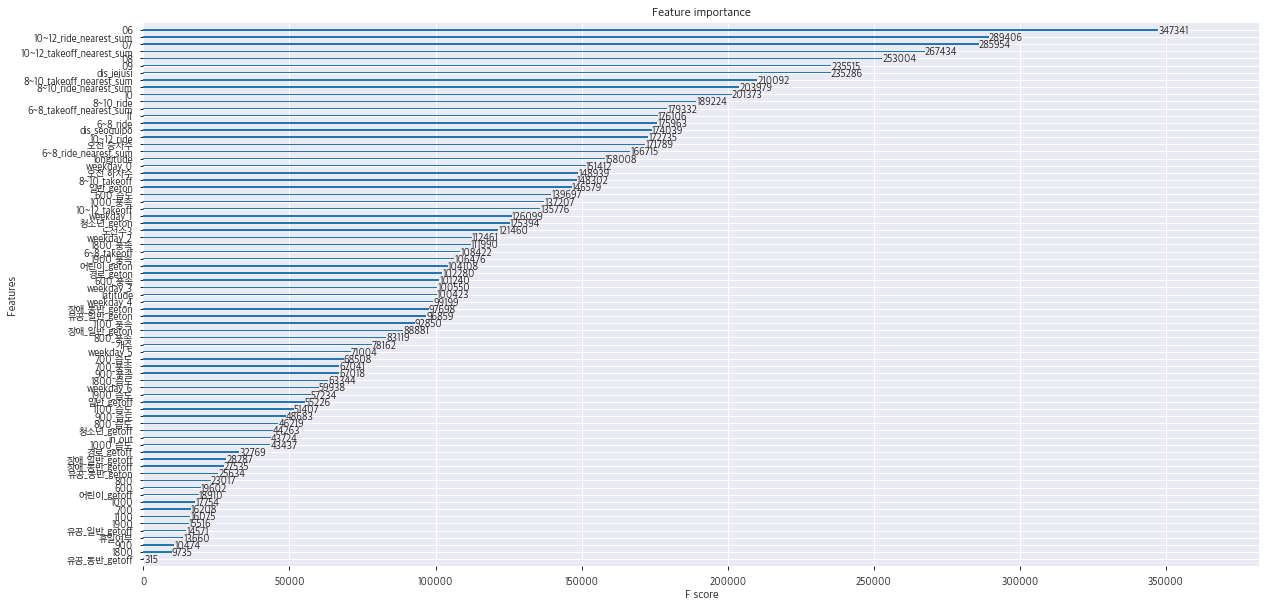

In [99]:
fig, ax = plt.subplots(figsize=(20, 10),facecolor='white')
plot_importance(xgb_model,ax=ax)
plt.show()

In [317]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [67]:
mse=mean_squared_error(y_test, y_pred_rf)
rmse=sqrt(mse)

In [68]:
print(mse)
print(rmse)

5.885364606247543
2.425977041574702


In [70]:
rnd_clf.feature_importances_

array([3.48125997e-04, 1.06383870e-03, 1.01670925e-03, 1.19029723e-03,
       8.72694756e-04, 7.39773200e-04, 6.98962191e-04, 1.02157626e-03,
       1.26598044e-02, 1.71994023e-02, 2.37277934e-02, 2.34204852e-02,
       2.11074804e-02, 2.22900575e-02, 1.36641854e-02, 1.28814626e-02,
       1.61501309e-02, 1.29162841e-02, 1.71068977e-02, 3.22676588e-02,
       1.52742538e-02, 3.00140132e-02, 1.29154878e-02, 2.34018770e-02,
       5.78650091e-03, 5.45181977e-03, 5.17182108e-03, 4.95227582e-03,
       4.63952285e-03, 4.79656176e-03, 4.77951733e-03, 4.95948810e-03,
       6.19233637e-03, 5.83370665e-03, 5.94891754e-03, 6.20904373e-03,
       5.95260348e-03, 5.63640802e-03, 5.84938250e-03, 5.76629286e-03,
       3.32975619e-02, 6.06517099e-02, 1.00044423e-01, 1.26124110e-02,
       1.88446382e-02, 2.33177648e-02, 1.03490689e-01, 3.28705834e-02,
       1.55050353e-03, 1.52534532e-03, 1.54792647e-03, 9.83323720e-04,
       1.63257878e-03, 1.00626743e-02, 1.56207967e-02, 2.56975171e-02,
      

In [79]:
feature_importances = pd.DataFrame(rnd_clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [83]:
p=feature_importances.reset_index()

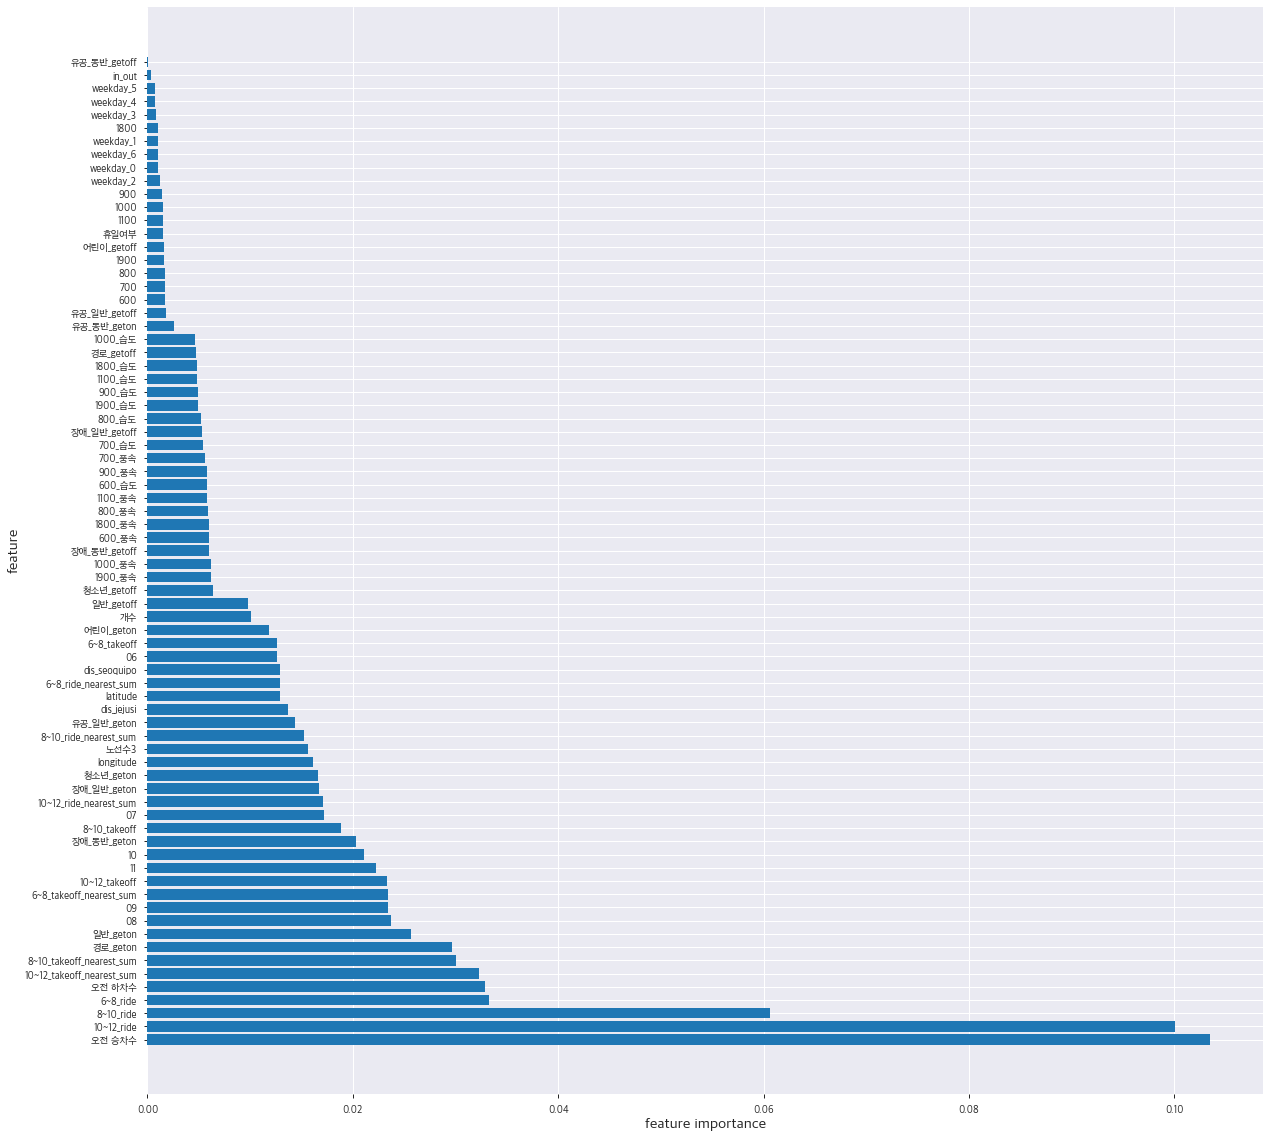

In [89]:
plt.figure(figsize=(20,20),facecolor='white')

plt.barh(p['index'], p['importance'], align='center')

plt.xlabel('feature importance', size=15)

plt.ylabel('feature', size=15)

plt.show()

In [353]:
print(mse)
print(rmse)

7.195644701186959
2.6824698882162608


In [95]:
mse=mean_squared_error(y_test, y_pred)
rmse=sqrt(mse)

In [96]:
# 일자별 노선별 시간별 버스 수
print(mse)
print(rmse)

6.696569440803132
2.587773065939734


In [0]:
# route별 버스 수
print(mse)
print(rmse)

10.353684345950262
3.2177141491981947


In [0]:
# 노선별 버스 수 + 노선과 정류장 별 승객별 탑승수 평균
print(mse)
print(rmse)

10.111315060801656
3.179829407499977


In [0]:
# 노선별 버스 수 + 노선과 정류장 별 승객별 하차수 평균
print(mse)
print(rmse)

10.20049819369192
3.193821878829801


In [0]:
test1=pd.merge(test,df1,on=['bus_route_id','date'],how='left')

In [0]:
df_bus1=df.groupby(['bus_route_id'])['vhc_id'].nunique().to_frame('vhc_id').reset_index()

In [0]:
df_bus1

,bus_route_id,vhc_id
0,4270000,21
1,4280000,21
2,7990000,1
3,8170000,13
4,8180000,13
...,...,...
625,32770000,1
626,32780000,2
627,32790000,1
628,32810000,14


In [0]:
train.groupby(['station_code'])['bus_route_id'].count()

station_code
1          132
2          352
3          144
4          393
5          246
          ... 
6115048      8
6115052     27
6115059     19
6115100    440
6115101    262
Name: bus_route_id, Length: 3563, dtype: int64

In [0]:
train2

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,vhc_id
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,21.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,21.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,21.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,21.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,14.0
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,14.0
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,14.0
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,14.0


In [0]:
df_people=df.groupby(['bus_route_id','getoff_date','getoff_station_code','user_category'])['user_count'].mean().to_frame('user_count').reset_index()

In [0]:
df_people

,bus_route_id,getoff_date,getoff_station_code,user_category,user_count
0,4270000,2019-09-01,1636.0,1,1.0
1,4270000,2019-09-01,1646.0,1,1.0
2,4270000,2019-09-01,1648.0,1,1.0
3,4270000,2019-09-01,1660.0,1,1.0
4,4270000,2019-09-01,1666.0,1,1.0
...,...,...,...,...,...
614628,32820000,2019-10-16,737.0,1,1.0
614629,32820000,2019-10-16,786.0,1,1.0
614630,32820000,2019-10-16,1080.0,1,1.0
614631,32820000,2019-10-16,6115100.0,1,1.0


In [0]:
df_people1 = df_people.pivot_table('user_count', ['bus_route_id','getoff_date','getoff_station_code'], 'user_category')

In [0]:
df_people1.to_csv('몰라3.csv')

In [0]:
df_people1=pd.read_csv('몰라3.csv')

In [0]:
df_people1['getoff_date'] = pd.to_datetime(df_people1['getoff_date'])

In [0]:
df_people1.rename(columns={'getoff_date':'date'},inplace=True)

In [0]:
df_people1.rename(columns={'getoff_station_code':'station_code'},inplace=True)

In [0]:
df_people1

,bus_route_id,date,station_code,1,2,4,6,27,28,29,30
0,4270000,2019-09-01,1636.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4270000,2019-09-01,1646.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4270000,2019-09-01,1648.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4270000,2019-09-01,1660.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4270000,2019-09-01,1666.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
395007,32820000,2019-10-15,6115100.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
395008,32820000,2019-10-16,737.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395009,32820000,2019-10-16,786.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395010,32820000,2019-10-16,1080.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
df_people1.rename(columns={'1':'1_drop','2':'2_drop','4':'4_drop','6':'6_drop',
                         '27':'27_drop','28':'28_drop','29':'29_drop','30':'30_drop'}, inplace=True)

In [0]:
df_people1

,bus_route_id,date,station_code,1_drop,2_drop,4_drop,6_drop,27_drop,28_drop,29_drop,30_drop
0,4270000,2019-09-01,1636.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4270000,2019-09-01,1646.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4270000,2019-09-01,1648.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4270000,2019-09-01,1660.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4270000,2019-09-01,1666.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
395007,32820000,2019-10-15,6115100.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
395008,32820000,2019-10-16,737.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395009,32820000,2019-10-16,786.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395010,32820000,2019-10-16,1080.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train3=pd.merge(train2,df_people1,on=['bus_route_id','date','station_code'],how='left')

In [0]:
train3

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,06,07,08,09,10,11,1,2,4,6,27,28,29,30,1_drop,2_drop,4_drop,6_drop,27_drop,28_drop,29_drop,30_drop
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train2

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,06,07,08,09,10,11,1,2,4,6,27,28,29,30
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,1.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
train.groupby(['station_name'])['bus']

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,dis_jejusi,dis_seoquipo,노선수
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2.954920,26.256744,NaN
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,3.720275,26.403025,132.0
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,5.036124,25.893305,352.0
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,2.864166,27.997494,144.0
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,29.040353,13.574693,393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,0,1129,한림환승정류장(한림리),33.41437,126.26336,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,25.950139,32.385460,NaN
415419,415419,2019-09-30,32820000,0,1564,제주시외버스터미널,33.49946,126.51479,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0.754801,26.927069,NaN
415420,415420,2019-09-30,32820000,0,2322,해병부대,33.23100,126.26273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,38.482046,27.717482,NaN
415421,415421,2019-09-30,32820000,0,3291,애월환승정류장(애월리),33.46483,126.31870,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,19.380000,31.873252,NaN


In [0]:
train_station

station_code
1           5
2          14
3           6
4          13
5           7
           ..
6115026     1
6115047     1
6115052     1
6115100    15
6115101     8
Name: bus_route_id, Length: 2552, dtype: int64

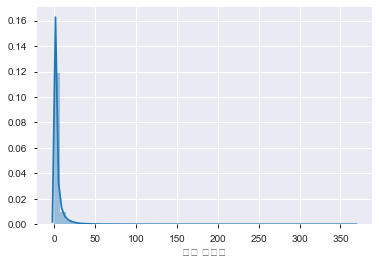

In [0]:
sns.distplot(train11['오전 승차수'])

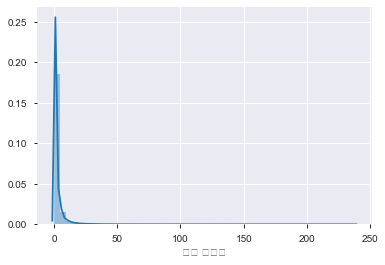

In [0]:
sns.distplot(train11['오전 하차수'])

In [0]:
df0=pd.read_csv('동 크롤링.csv')
split = df0['동'].str.split(' ')
split = split.apply(lambda x: pd.Series(x))
split[4]=split[3]+ ' ' +split[1]
df0['시동']=split[4]
del df0['Unnamed: 0']
del df0['동']
df0.rename(columns={'0':'좌표'},inplace=True)
df0
train['좌표']=train['latitude'].astype(str)+','+train['longitude'].astype(str)
pd.merge(train,df0,on='좌표',how='left')

In [212]:
split = df0['동'].str.split(' ')

In [213]:
split = split.apply(lambda x: pd.Series(x))

In [214]:
split

,0,1,2,3
0,FFQV+XF,연동,제주특별자치도,제주시
1,FFQP+Q2,연동,제주특별자치도,제주시
2,FFJF+PC,노형동,제주특별자치도,제주시
3,GF4V+82,용담2동,제주특별자치도,제주시
4,7C47+82,예래동,제주특별자치도,서귀포시
...,...,...,...,...
3595,FJX9+XX,봉개동,제주특별자치도,제주시
3596,852Q+RM,한경면,제주특별자치도,제주시
3597,67C8+9Q,대정읍,제주특별자치도,서귀포시
3598,FMV2+48,조천읍,제주특별자치도,제주시


In [215]:
split[4]=split[3]+ ' ' +split[1]

In [216]:
df0['시동']=split[4]

In [217]:
del df0['Unnamed: 0']

In [218]:
del df0['동']

In [65]:
df=pd.read_csv('원본_train.csv')

In [66]:
df.isnull().sum()

Unnamed: 0                        0
id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
18~20_ride                        0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                   

In [71]:
list(df.columns)

['Unnamed: 0',
 'id',
 'date',
 'bus_route_id',
 'in_out',
 'station_code',
 'station_name',
 'latitude',
 'longitude',
 '6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff',
 '18~20_ride',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 'geton_station_code_getoff',
 '노선수',
 'getoff_station_code',
 '노선수1',
 '노선수3',
 'dis_jejusi',
 'dis_seoquipo',
 'dis',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '일반_getoff',
 '어린이_getoff',
 '청소년_getoff',
 '경로_getoff',
 '장애_일반_getoff',
 '장애_동반_getoff',
 '유공_일반_getoff',
 '유공_동반_getoff',
 '오전 하차수',
 '오전 승차수',
 '좌표',
 '동',
 '휴일여부',
 '1000_강수여부',
 '1100_강수여부',
 '1800_강수여부',
 '1900_강수여부',
 '600_강수여부',
 '700_강수여부',
 '800_강수여부',
 '900_강수여부',
 '600_습도',
 '700_습도',
 '800_습도',
 '900_습도',
 '1000_습도',
 '1100_습도',
 '1800_습도',
 '1900_습도',
 '1000_풍향',
 '1100_풍향',
 '1800_풍향',
 '1900_풍향',
 '6

In [69]:
df['06'].median()

1.0

In [72]:
ls=['06',
 '07',
 '08',
 '09',
 '10',
 '11',
'일반_getoff',
 '어린이_getoff',
 '청소년_getoff',
 '경로_getoff',
 '장애_일반_getoff',
 '장애_동반_getoff',
 '유공_일반_getoff',
 '유공_동반_getoff',
   '일반_geton',
 '어린이_geton',
 '청소년_geton',
 '경로_geton',
 '장애_일반_geton',
 '장애_동반_geton',
 '유공_일반_geton',
 '유공_동반_geton' ]

In [73]:
for i in ls:
    df[i]=df[i].fillna(df[i].median)

In [74]:
df.isnull().sum()

Unnamed: 0                      0
id                              0
date                            0
bus_route_id                    0
in_out                          0
station_code                    0
station_name                    0
latitude                        0
longitude                       0
6~7_ride                        0
7~8_ride                        0
8~9_ride                        0
9~10_ride                       0
10~11_ride                      0
11~12_ride                      0
6~7_takeoff                     0
7~8_takeoff                     0
8~9_takeoff                     0
9~10_takeoff                    0
10~11_takeoff                   0
11~12_takeoff                   0
18~20_ride                      0
weekday_0                       0
weekday_1                       0
weekday_2                       0
weekday_3                       0
weekday_4                       0
weekday_5                       0
weekday_6                       0
geton_station_

In [242]:
df_train=pd.read_csv('원본_train.csv')

In [243]:
df_test=pd.read_csv('원본_test.csv')

In [244]:
df_train.drop(columns=['Unnamed: 0'],inplace=True)

In [245]:
pd.set_option('display.max_columns',999)

In [246]:
df_train

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,2.0,6.0,4.0,5.0,6.0,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.0,"33.4899,126.49373",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,0.0,1.0,0.0,67,1.0,7.0,8.0,0.0,0.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,22.0,"33.48944,126.48508",제주시 연동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,57.0,40.0,53.0,67.0,15.0,11.0,37.0,36.0,44.0,121.0,85.0,100.0,111.0,51.0,48.0,67,5.0,6.0,11.0,0.0,0.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073
2,2,2019-09-01,4270000,1,432,정존마을,33.48181,126.47352,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,"33.48181,126.47352",제주시 노형동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,12.0,7.0,17.0,14.0,4.0,1.0,2.0,4.0,15.0,26.0,15.0,27.0,29.0,8.0,3.0,105,2.0,2.0,0.0,0.0,0.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000
3,3,2019-09-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,0,0,0,0,0,0,1,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,2.0,6.0,4.0,5.0,6.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,79.0,"33.50577,126.49252",제주시 용담2동,1,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,86.0,91.0,96.0,98.0,96.0,96.0,96.0,97.0,106.0,100.0,60.0,58.0,122.0,80.0,171.0,67.0,3.3,1.9,3.0,4.0,2.1,1.8,0.7,3.6,1.5,2.8,0.0,0.0,0.0,0.4,3.0,9.0,26.0,55.0,27.0,61.0,7.0,75.0,99.0,22.0,61.0,77.0,111.0,51.0,122.0,29.0,174.0,56,17.0,32.0,30.0,0.0,0.0,0.0,1579.0,0.976156,0.013247,0.009634,0.000482,0.000000,0.000482,0.000000,0.000000
4,4,2019-09-01,4270000,0,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1646.0,9.0,1646.0,1

In [350]:
df_jeju=pd.read_csv('제주시 9월인구.csv')
df_seo=pd.read_csv('서귀포시 9월인구.csv')

In [351]:
df_jeju['동']='제주시'+ ' ' + df_jeju['Unnamed: 0']
df_jeju.drop(columns=['Unnamed: 0'],inplace=True)

In [358]:
df_jeju=df_jeju[['세대','합계','동']]
df_seo=df_seo[['세대','합계','동']]

In [359]:
df_jeju

,세대,합계,동
0,10369,25084,제주시 한림읍
1,16012,37194,제주시 애월읍
2,7712,16323,제주시 구좌읍
3,10796,25114,제주시 조천읍
4,4671,9423,제주시 한경면
5,1042,2079,제주시 추자면
6,1009,1915,제주시 우도면
7,1588,2868,제주시 일도1동
8,13231,34208,제주시 일도이동
9,3640,7815,제주시 이도1동


In [352]:
df_jeju.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
df_jeju.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
df_jeju.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)

In [353]:
df_seo['동']='서귀포시' + df_seo['Unnamed: 0']
df_seo.drop(columns=['Unnamed: 0'],inplace=True)

In [354]:
list1=[]
for i in df_seo['동']:
    list1.append(i.strip())
df_seo['동']=list1

In [360]:
df_seo

,세대,합계,동
0,10024,23162,서귀포시 대정읍
1,8497,19860,서귀포시 남원읍
2,7980,17396,서귀포시 성산읍
3,6147,12749,서귀포시 안덕면
4,6039,12775,서귀포시 표선면
5,2042,4876,서귀포시 송산동
6,1317,2406,서귀포시 정방동
7,2058,3851,서귀포시 중앙동
8,1932,3677,서귀포시 천지동
9,2279,5380,서귀포시 효돈동


In [361]:
df_con=pd.concat([df_jeju,df_seo])

In [362]:
df_merge=pd.merge(df9,df_con,on='동',how='left')

In [363]:
df_merge

id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
18~20_ride                        0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                   

In [410]:
df_merge2=pd.merge(df_merge1,df_con_peo,on='동',how='left')

In [411]:
df_merge2.isnull().sum()

id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
18~20_ride                        0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                   

In [413]:
df_merge2.to_csv('train_추가.csv')

In [416]:
df_merge2

AttributeError: 'Series' object has no attribute 'type'

In [30]:
pd.set_option('display.max_rows',999)

In [151]:
df_merge.to_csv('train_인구포함.csv')

In [337]:
df_jeju=pd.read_csv('제주시 10월인구.csv')
df_seo=pd.read_csv('서귀포시 10월인구.csv')

In [338]:
df_jeju['동']='제주시'+ ' ' + df_jeju['Unnamed: 0']
df_jeju.drop(columns=['Unnamed: 0'],inplace=True)

In [339]:
df_jeju.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
df_jeju.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
df_jeju.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)

In [340]:
df_jeju['동'].unique()

array(['제주시 한림읍', '제주시 애월읍', '제주시 구좌읍', '제주시 조천읍', '제주시 한경면', '제주시 추자면',
       '제주시 우도면', '제주시 일도1동', '제주시 일도이동', '제주시 이도1동', '제주시 이도2동',
       '제주시 삼도일동', '제주시 삼도2동', '제주시 용담일동', '제주시 용담2동', '제주시 건입동',
       '제주시 화북동', '제주시 삼양동', '제주시 봉개동', '제주시 아라동', '제주시 오라동', '제주시 연동',
       '제주시 노형동', '제주시 외도동', '제주시 이호동', '제주시 도두동'], dtype=object)

In [341]:
df_seo['동']='서귀포시' + df_seo['Unnamed: 0']
df_seo.drop(columns=['Unnamed: 0'],inplace=True)

In [342]:
df_seo['동'].unique()

array(['서귀포시 대정읍 ', '서귀포시 남원읍 ', '서귀포시 성산읍 ', '서귀포시 안덕면 ', '서귀포시 표선면 ',
       '서귀포시 송산동 ', '서귀포시 정방동 ', '서귀포시 중앙동 ', '서귀포시 천지동 ', '서귀포시 효돈동 ',
       '서귀포시 영천동 ', '서귀포시 동홍동 ', '서귀포시 서홍동 ', '서귀포시 대륜동 ', '서귀포시 대천동 ',
       '서귀포시 중문동 ', '서귀포시 예래동 '], dtype=object)

In [343]:
df_con=pd.concat([df_jeju,df_seo])

In [181]:
df_test=pd.read_csv('원본_test.csv')

In [183]:
df_merge=pd.merge(df_test,df_con,on='동',how='left')

In [184]:
df_merge.isnull().sum()

Unnamed: 0                        0
id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                   

In [185]:
df_merge.to_csv('test_인구포함.csv')

In [460]:
df=pd.read_csv('test_인구포함.csv')

In [461]:
del df['Unnamed: 0']

In [462]:
df1=pd.read_excel('제주도 사업체.xlsx',sheet_name='제주시')
df2=pd.read_excel('제주도 사업체.xlsx',sheet_name='서귀포시')

In [466]:
split = df2['지역'].str.split('.')
split = split.apply(lambda x: pd.Series(x))

In [467]:
split

,0,1
0,3902011,대정읍
1,3902011,대정읍
2,3902011,대정읍
3,3902011,대정읍
4,3902011,대정읍
5,3902011,대정읍
6,3902011,대정읍
7,3902011,대정읍
8,3902011,대정읍
9,3902011,대정읍


In [465]:
df1['동']='제주시'+ ' ' + split[1] 

In [468]:
df2['동']='서귀포시'+ ' ' + split[1] 

In [469]:
df_je_com=df1.groupby(['동'])['업체수'].sum().reset_index()

In [470]:
df_je_peo=df1.groupby(['동'])['종사자수'].sum().reset_index()

In [471]:
df_seo_com=df2.groupby(['동'])['업체수'].sum().reset_index()

In [472]:
df_seo_peo=df2.groupby(['동'])['종사자수'].sum().reset_index()

In [475]:
df_con_com=pd.concat([df_je_com,df_seo_com]).reset_index().drop(columns=['index'])

In [476]:
df_con_com

,동,업체수
0,제주시 건입동,1736.0
1,제주시 구좌읍,3322.0
2,제주시 노형동,9436.0
3,제주시 도두동,1946.0
4,제주시 봉개동,564.0
5,제주시 삼도1동,3012.0
6,제주시 삼도2동,2180.0
7,제주시 삼양동,2156.0
8,제주시 아라동,4152.0
9,제주시 애월읍,4964.0


In [477]:
df_con_com.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
df_con_com.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
df_con_com.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)

In [478]:
df_con_peo.replace({'동': '제주시 일도2동'}, {'동': '제주시 일도이동'},inplace=True)
df_con_peo.replace({'동': '제주시 삼도1동'}, {'동': '제주시 삼도일동'},inplace=True)
df_con_peo.replace({'동': '제주시 용담1동'}, {'동': '제주시 용담일동'},inplace=True)

In [479]:
df0=pd.read_excel('정류장 동 매칭.xlsx')

In [481]:
df0

,Unnamed: 0,0,Unnamed: 2
0,0,뉴경남호텔,서귀포시 천지동
1,1,서복전시관,서귀포시 송산동
2,2,중앙로터리(동),서귀포시 중앙동
3,3,제주은행,서귀포시 중앙동
4,4,동미빌딩,서귀포시 중앙동
5,5,동문로터리,서귀포시 정방동
6,6,중앙로터리,서귀포시 중앙동
7,7,천지동주민센터,서귀포시 천지동
8,8,청소년문화의집,서귀포시 중앙동
9,9,아랑조을거리입구,서귀포시 천지동


In [483]:
df0['동1']=df0['동']

In [485]:
df0

,Unnamed: 0,station_name,동,동1
0,0,뉴경남호텔,서귀포시 천지동,서귀포시 천지동
1,1,서복전시관,서귀포시 송산동,서귀포시 송산동
2,2,중앙로터리(동),서귀포시 중앙동,서귀포시 중앙동
3,3,제주은행,서귀포시 중앙동,서귀포시 중앙동
4,4,동미빌딩,서귀포시 중앙동,서귀포시 중앙동
5,5,동문로터리,서귀포시 정방동,서귀포시 정방동
6,6,중앙로터리,서귀포시 중앙동,서귀포시 중앙동
7,7,천지동주민센터,서귀포시 천지동,서귀포시 천지동
8,8,청소년문화의집,서귀포시 중앙동,서귀포시 중앙동
9,9,아랑조을거리입구,서귀포시 천지동,서귀포시 천지동


In [292]:
df_train[df_train['station_name']=='뉴경남호텔']

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton
10,10,2019-09-01,4270000,1,2009,뉴경남호텔,33.24613,126.55957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0,0,0,0,0,0,1,2009.0,4.0,2009.0,8.0,8.0,28.449369,1.480357,1.480357,2.0,6.0,4.0,5.0,6.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,"33.24613,126.55957",서귀포시 서귀동,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,49.0,33.0,34.0,21.0,57.0,59.0,53.0,58.0,2.7,2.1,1.5,1.6,2.7,2.4,2.0,3.1,0.2,3.6,0.0,0.2,0.0,0.0,5.000000,0.8,3.0,1.0,2.0,2.0,0.0,2.0,3.0,0.0,4.0,6.0,5.0,3.0,6.0,0.0,5.0,43,0.0,0.0,0.0,0.0,1.0,4.0,2009.0,0.800000,0.000000,0.000000,0.2,0.0,0.0,0.0,0.0
43,43,2019-09-01,4280000,1,2104,뉴경남호텔,33.24671,126.55825,4.0,1.0,3.0,6.0,2.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,0,1,2104.0,6.0,2104.0,6.0,6.0,28.370949,1.410655,1.410655,3.0,5.0,7.0,7.0,7.0,6.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.0,21.0,"33.24671,126.55825",서귀포시 서귀동,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,49.0,33.0,34.0,21.0,57.0,59.0,53.0,58.0,2.7,2.1,1.5,1.6,2.7,2.4,2.0,3.1,0.2,3.6,0.0,0.2,0.0,0.0,5.000000,0.8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,2.0,0.0,0.0,43,5.0,9.0,7.0,0.0,0.0,0.0,2104.0,0.990269,0.006737,0.002994,0.0,0.0,0.0,0.0,0.0
10333,10333,2019-09-01,31750000,1,2009,뉴경남호텔,33.24613,126.55957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,1,2009.0,4.0,2009.0,8.0,8.0,28.449369,1.480357,1.480357,1.0,1.0,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,"33.24613,126.55957",서귀포시 서귀동,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,49.0,33.0,34.0,21.0,57.0,59.0,53.0,58.0,2.7,2.1,1.5,1.6,2.7,2.4,2.0,3.1,0.2,3.6,0.0,0.2,0.0,0.0,5.000000,0.8,3.0,1.0,2.0,2.0,0.0,2.0,3.0,0.0,4.0,6.0,5.0,3.0,6.0,0.0,5.0,43,0.0,0.0,0.0,0.0,1.0,0.0,2009.0,0.800000,0.000000,0.000000,0.2,0.0,0.0,0.0,0.0
10375,10375,2019-09-01,31760000,1,2104,뉴경남호텔,33.24671,126.55825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,0,0,1,2104.0,6.0,2104.0,6.0,6.0,28.370949,1.410655,1.410655,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,"33.24671,126.55825",서귀포시 서귀동,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,99.0,49.0,33.0,34.0,21.0,57.0,59.0,53.0,58.0,2.7,2.1,1.5,1.6,2.7,2.4,2.0,3.1,0.2,3.6,0.0,0.2,0.0,0.0,5.000000,0.8,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,2.0,0.0,0.0,43,0.0,0.0,0.0,0.0,0.0,1.0,2104.0,0.990269,0.006737,0.002994,0.0,0.0,0.0,0.0,0.0
11549,11549,2019-09-02,4270000,1,2009,뉴경남호텔,33.24613,126.55957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1,0,0,0,0,0,0,2009.0,4.0,2009.0,8.0,8.0,28.449369,1.480357,1.480357,2.0,7.0,5.0,6.0,6.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,"33.24613,126.5595

In [482]:
df0.rename(columns={0:'station_name','Unnamed: 2':'동'},inplace=True)

In [486]:
df0.drop(columns=['Unnamed: 0'],inplace=True)

In [487]:
df0['station_name'].unique()

array(['뉴경남호텔', '서복전시관', '중앙로터리(동)', '제주은행', '동미빌딩', '동문로터리', '중앙로터리',
       '천지동주민센터', '청소년문화의집', '아랑조을거리입구', '현대산부인과', '평생학습관', '매일올레시장7번입구',
       '서귀포시구시외버스터미널', '구터미널', '남군농협', '서문로터리입구', '(구)중앙파출소', '열린병원',
       '오션팰리스호텔', '서귀포중학교', '제석공원', '서귀포농협', '서귀포보건소', '구삼일금고', '솔동산입구',
       '송산동주민센터', '정방동문화의집'], dtype=object)

In [488]:
df9=pd.merge(df,df0,on=['동','station_name'],how='left')

In [489]:
df9

,Unnamed: 0.1,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,동,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,10~12_ride,10~12_takeoff,6~8_ride,6~8_takeoff,7~9_ride,7~9_takeoff,8~10_ride,8~10_takeoff,9~11_ride,9~11_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton,세대,합계,한국인(합계),한국인(남),한국인(여),외국인(합계),외국인(남),외국인(여),동1
0,0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,"33.4899,126.49373",제주시 연동,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,68,10.0,1.0,8.0,0.0,11.0,0.0,9.0,0.0,11.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19845.0,43693.0,41522.0,20383.0,21139.0,2171.0,1046.0,1125.0,NaN
1,1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33.0,"33.48944,126.48508",제주시 연동,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,112.0,65.0,124.0,118.0,26.0,22.0,71.0,140.0,83.0,201.0,127.0,253.0,201.0,166.0,93.0,68,19.0,0.0,7.0,0.0,12.0,0.0,7.0,0.0,9.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073,19845.0,43693.0,41522.0,20383.0,21139.0,2171.0,1046.0,1125.0,NaN
2,2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.0,"33.48181,126.47352",제주시 노형동,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,13.0,23.0,36.0,40.0,2.0,3.0,7.0,24.0,17.0,24.0,28.0,67.0,57.0,26.0,10.0,102,3.0,0.0,6.0,0.0,6.0,0.0,4.0,0.0,4.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000,21483.0,56416.0,53953.0,26514.0,27439.0,2463.0,1373.0,1090.0,NaN
3,3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.0,"33.50577,126.49252",제주시 용담2동,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,

In [490]:
df9['동1']=df9['동1'].fillna(df9['동'])

In [491]:
df9.drop(columns=['동'],inplace=True)

In [492]:
df9.rename(columns={'동1':'동'},inplace=True)

In [493]:
df9.isnull().sum()

Unnamed: 0.1                      0
id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                   

In [494]:
df9.drop(columns=['한국인(합계)','한국인(남)','한국인(여)','외국인(합계)','외국인(남)','외국인(여)'],inplace=True)

In [497]:
df9.drop(columns=['Unnamed: 0.1'],inplace=True)

In [498]:
list1=[]
for i in df9['동']:
    a=i[-1:]
    list1.append(a)

In [499]:
df9['읍면동']=list1

In [501]:
df9.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,10~12_ride,10~12_takeoff,6~8_ride,6~8_takeoff,7~9_ride,7~9_takeoff,8~10_ride,8~10_takeoff,9~11_ride,9~11_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton,세대,합계,동,읍면동
0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,"33.4899,126.49373",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,68,10.0,1.0,8.0,0.0,11.0,0.0,9.0,0.0,11.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19845.0,43693.0,제주시 연동,동
1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33.0,"33.48944,126.48508",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,112.0,65.0,124.0,118.0,26.0,22.0,71.0,140.0,83.0,201.0,127.0,253.0,201.0,166.0,93.0,68,19.0,0.0,7.0,0.0,12.0,0.0,7.0,0.0,9.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073,19845.0,43693.0,제주시 연동,동
2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.0,"33.48181,126.47352",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,13.0,23.0,36.0,40.0,2.0,3.0,7.0,24.0,17.0,24.0,28.0,67.0,57.0,26.0,10.0,102,3.0,0.0,6.0,0.0,6.0,0.0,4.0,0.0,4.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000,21483.0,56416.0,제주시 노형동,동
3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.0,"33.50577,126.49252",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,23.0,62.0,35.0,78.0,3.0,54.0,96.0,29.0,66.0,72.0,126.0,92.0,144.0,32.0,150.0,56,46.0,0.0,12.0,0.0,29.0,0.0,26.0,0.0,34.0,0.0,1579.0,0.976156,0.013247,0.009634,0.000482,0.000000,0.000482,0.000000,0.000000,64

In [503]:
df9=pd.get_dummies(df9,columns=['읍면동'])

In [504]:
df9

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,10~12_ride,10~12_takeoff,6~8_ride,6~8_takeoff,7~9_ride,7~9_takeoff,8~10_ride,8~10_takeoff,9~11_ride,9~11_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton,세대,합계,동,읍면동_동,읍면동_면,읍면동_읍
0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,"33.4899,126.49373",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,68,10.0,1.0,8.0,0.0,11.0,0.0,9.0,0.0,11.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19845.0,43693.0,제주시 연동,1,0,0
1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33.0,"33.48944,126.48508",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,112.0,65.0,124.0,118.0,26.0,22.0,71.0,140.0,83.0,201.0,127.0,253.0,201.0,166.0,93.0,68,19.0,0.0,7.0,0.0,12.0,0.0,7.0,0.0,9.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073,19845.0,43693.0,제주시 연동,1,0,0
2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.0,"33.48181,126.47352",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,13.0,23.0,36.0,40.0,2.0,3.0,7.0,24.0,17.0,24.0,28.0,67.0,57.0,26.0,10.0,102,3.0,0.0,6.0,0.0,6.0,0.0,4.0,0.0,4.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000,21483.0,56416.0,제주시 노형동,1,0,0
3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.0,"33.50577,126.49252",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,23.0,62.0,35.0,78.0,3.0,54.0,96.0,29.0,66.0,72.0,126.0,92.0,144.0,32.0,150.0,56,46.0,0.0,12.0,0.0,29.0,0.0,26.0,0.0,34.0,0.0,1579.0,0.976156,0.013247,0.009634,0.000482,0.000000,0.0

In [505]:
import json

In [506]:
with open('bri_cluster.json', 'r') as f:
    bri_cluster = json.load(f)

In [507]:
with open('sc_cluster.json', 'r') as f:
    sc_cluster = json.load(f)

In [508]:
df9['bus_route_cluster'] = df9['bus_route_id'].apply(lambda x: bri_cluster[str(x)])

In [509]:
df9['station_cluster'] = df9['station_code'].apply(lambda x: sc_cluster[str(x)])

In [510]:
df9.isnull().sum()

id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                         0
geton_station_code_getoff   

In [458]:
df.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)

In [512]:
df9.to_csv('test_cluster.csv',index=False)

In [515]:
df=pd.read_csv('train_cluster.csv')

In [517]:
for i in ls:
    df9[i].fillna(df.groupby('동')[i].transform('mean'),inplace=True)

In [519]:
df9.isnull().sum()

id                                0
date                              0
bus_route_id                      0
in_out                            0
station_code                      0
station_name                      0
latitude                          0
longitude                         0
6~7_ride                          0
7~8_ride                          0
8~9_ride                          0
9~10_ride                         0
10~11_ride                        0
11~12_ride                        0
6~7_takeoff                       0
7~8_takeoff                       0
8~9_takeoff                       0
9~10_takeoff                      0
10~11_takeoff                     0
11~12_takeoff                     0
weekday_0                         0
weekday_1                         0
weekday_2                         0
weekday_3                         0
weekday_4                         0
weekday_5                         0
weekday_6                         0
geton_station_code_getoff   

In [513]:
df9

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,10~12_ride,10~12_takeoff,6~8_ride,6~8_takeoff,7~9_ride,7~9_takeoff,8~10_ride,8~10_takeoff,9~11_ride,9~11_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton,세대,합계,동,읍면동_동,읍면동_면,읍면동_읍,bus_route_cluster,station_cluster
0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,27.0,"33.4899,126.49373",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,68,10.0,1.0,8.0,0.0,11.0,0.0,9.0,0.0,11.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19845.0,43693.0,제주시 연동,1,0,0,3,6
1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,33.0,"33.48944,126.48508",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,112.0,65.0,124.0,118.0,26.0,22.0,71.0,140.0,83.0,201.0,127.0,253.0,201.0,166.0,93.0,68,19.0,0.0,7.0,0.0,12.0,0.0,7.0,0.0,9.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073,19845.0,43693.0,제주시 연동,1,0,0,3,6
2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,13.0,"33.48181,126.47352",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,13.0,23.0,36.0,40.0,2.0,3.0,7.0,24.0,17.0,24.0,28.0,67.0,57.0,26.0,10.0,102,3.0,0.0,6.0,0.0,6.0,0.0,4.0,0.0,4.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000,21483.0,56416.0,제주시 노형동,1,0,0,3,1
3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,4.0,8.0,7.0,4.0,5.0,5.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.0,"33.50577,126.49252",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,23.0,62.0,35.0,78.0,3.0,54.0,96.0,29.0,66.0,72.0,126.0,92.0,144.0,32.0,150.0,56,46.0,0.0,12.0,0.0,29.0,0.0,26.0,0.0,34.0,0.0,1579.0,0.

In [514]:
ls=['06',
 '07',
 '08',
 '09',
 '10',
 '11',
'일반_getoff',
 '어린이_getoff',
 '청소년_getoff',
 '경로_getoff',
 '장애_일반_getoff',
 '장애_동반_getoff',
 '유공_일반_getoff',
 '유공_동반_getoff',
  '일반_geton',
 '어린이_geton',
 '청소년_geton',
 '경로_geton',
 '장애_일반_geton',
 '장애_동반_geton',
 '유공_일반_geton',
 '유공_동반_geton' ]

In [528]:
col =[
 'in_out',
 'station_code',
 'latitude',
 'longitude',
 '6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 '노선수3',
 'dis_jejusi',
 'dis_seoquipo',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '일반_getoff',
 '어린이_getoff',
 '청소년_getoff',
 '경로_getoff',
 '장애_일반_getoff',
 '장애_동반_getoff',
 '유공_일반_getoff',
 '유공_동반_getoff',
 '오전 하차수',
 '오전 승차수',
 '휴일여부',
 '1000_강수여부',
 '1100_강수여부',
 '1800_강수여부',
 '1900_강수여부',
 '600_강수여부',
 '700_강수여부',
 '800_강수여부',
 '900_강수여부',
 '600_습도',
 '700_습도',
 '800_습도',
 '900_습도',
 '1000_습도',
 '1100_습도',
 '1800_습도',
 '1900_습도',
 '1000_풍향',
 '1100_풍향',
 '1800_풍향',
 '1900_풍향',
 '600_풍향',
 '700_풍향',
 '800_풍향',
 '900_풍향',
 '1000_풍속',
 '1100_풍속',
 '1800_풍속',
 '1900_풍속',
 '600_풍속',
 '700_풍속',
 '800_풍속',
 '900_풍속',
 '1000',
 '1100',
 '1800',
 '1900',
 '600',
 '700',
 '800',
 '900',
 '10~11_ride_nearest_sum',
 '10~11_takeoff_nearest_sum',
 '8~9_ride_nearest_sum',
 '8~9_takeoff_nearest_sum',
 '6~7_ride_nearest_sum',
 '6~7_takeoff_nearest_sum',
 '7~8_takeoff_nearest_sum',
 '7~8_ride_nearest_sum',
 '9~10_takeoff_nearest_sum',
 '10~12_ride_nearest_sum',
 '10~12_takeoff_nearest_sum',
 '8~10_ride_nearest_sum',
 '8~10_takeoff_nearest_sum',
 '6~8_ride_nearest_sum',
 '6~8_takeoff_nearest_sum',
 '개수',
 '6~8_ride',
 '8~10_ride',
 '10~12_ride',
 '6~8_takeoff',
 '8~10_takeoff',
 '10~12_takeoff',
 '일반_geton',
 '어린이_geton',
 '청소년_geton',
 '경로_geton',
 '장애_일반_geton',
 '장애_동반_geton',
 '유공_일반_geton',
 '유공_동반_geton',
 '세대',
 '합계',
 '업체수',
 '종사자수',
 '읍면동_동',
 '읍면동_면',
 '읍면동_읍',
 'bus_route_cluster',
'station_cluster']
df1 = df9[col]

In [529]:
df1

,in_out,station_code,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,노선수3,dis_jejusi,dis_seoquipo,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,6~8_ride,8~10_ride,10~12_ride,6~8_takeoff,8~10_takeoff,10~12_takeoff,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton,세대,합계,업체수,종사자수,읍면동_동,읍면동_면,읍면동_읍,bus_route_cluster,station_cluster
0,1,344,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,1.0,2.954920,26.256744,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.020715,1.009400,1.0,1.0,1.0,1.0,1.0,1.0,27.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,68,8.0,9.0,10.0,0.0,0.0,1.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19845.0,43693.0,9936.0,51994.0,1,0,0,3,6
1,1,357,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,75.0,3.720275,26.403025,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.020715,1.009400,1.0,1.0,1.0,1.0,1.0,0.0,33.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,112.0,65.0,124.0,118.0,26.0,22.0,71.0,140.0,83.0,201.0,127.0,253.0,201.0,166.0,93.0,68,7.0,7.0,19.0,0.0,0.0,0.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073,19845.0,43693.0,9936.0,51994.0,1,0,0,3,6
2,1,432,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,38.0,5.036124,25.893305,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.024585,1.008475,1.0,1.0,1.0,1.0,1.0,0.0,13.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,13.0,23.0,36.0,40.0,2.0,3.0,7.0,24.0,17.0,24.0,28.0,67.0,57.0,26.0,10.0,102,6.0,4.0,3.0,0.0,0.0,0.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000,21483.0,56416.0,9436.0,44056.0,1,0,0,3,1
3,0,1579,33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,3.0,2.864166,27.997494,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.039007,1.010201,1.0,1.0,1.0,1.0,NaN,0.0,84.0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,23.0,62.0,35.0,78.0,3.0,54.0,96.0,29.0,66.0,72.0,126.0,92.0,144.0,32.0,150.0,56,12.0,26.0,46.0,0.0,0.0,0.0,0.976156,0.013247,0.009634,0.000482,0.000000,0.000482,0.000000,0.000000,6426.0,15454.0,2542.0,14546.0,1,0,0,3,5
4,0,1636,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,0,0,0,0,0,2.0,29.849144,13.832783,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.028541,1.028736,1.008757,1.0,1.0,1.0,1.0,NaN,1.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,83.0,75.0,74.0,66.0,65.0,72.0,92.0,93.0,87.0,

In [522]:
df9=pd.merge(df9,df_con_com,on='동',how='left')

In [523]:
df9=pd.merge(df9,df_con_peo,on='동',how='left')

In [524]:
df9

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,geton_station_code_getoff,노선수,getoff_station_code,노선수1,노선수3,dis_jejusi,dis_seoquipo,dis,06,07,08,09,10,11,일반_getoff,어린이_getoff,청소년_getoff,경로_getoff,장애_일반_getoff,장애_동반_getoff,유공_일반_getoff,유공_동반_getoff,오전 하차수,오전 승차수,좌표,휴일여부,1000_강수여부,1100_강수여부,1800_강수여부,1900_강수여부,600_강수여부,700_강수여부,800_강수여부,900_강수여부,600_습도,700_습도,800_습도,900_습도,1000_습도,1100_습도,1800_습도,1900_습도,1000_풍향,1100_풍향,1800_풍향,1900_풍향,600_풍향,700_풍향,800_풍향,900_풍향,1000_풍속,1100_풍속,1800_풍속,1900_풍속,600_풍속,700_풍속,800_풍속,900_풍속,1000,1100,1800,1900,600,700,800,900,10~11_ride_nearest_sum,10~11_takeoff_nearest_sum,8~9_ride_nearest_sum,8~9_takeoff_nearest_sum,6~7_ride_nearest_sum,6~7_takeoff_nearest_sum,7~8_takeoff_nearest_sum,7~8_ride_nearest_sum,9~10_takeoff_nearest_sum,10~12_ride_nearest_sum,10~12_takeoff_nearest_sum,8~10_ride_nearest_sum,8~10_takeoff_nearest_sum,6~8_ride_nearest_sum,6~8_takeoff_nearest_sum,개수,10~12_ride,10~12_takeoff,6~8_ride,6~8_takeoff,7~9_ride,7~9_takeoff,8~10_ride,8~10_takeoff,9~11_ride,9~11_takeoff,geton_station_code_geton,일반_geton,어린이_geton,청소년_geton,경로_geton,장애_일반_geton,장애_동반_geton,유공_일반_geton,유공_동반_geton,세대,합계,동,읍면동_동,읍면동_면,읍면동_읍,bus_route_cluster,station_cluster,업체수,종사자수
0,415423,2019-10-01,4270000,1,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0,0,0,0,344.0,1.0,344.0,1.0,1.0,2.954920,26.256744,2.954920,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.020715,1.009400,1.0,1.0,1.0,1.0,1.0,1.0,27.0,"33.4899,126.49373",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,1.0,68,10.0,1.0,8.0,0.0,11.0,0.0,9.0,0.0,11.0,0.0,344.0,0.994334,0.005666,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19845.0,43693.0,제주시 연동,1,0,0,3,6,9936.0,51994.0
1,415424,2019-10-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,357.0,59.0,357.0,75.0,75.0,3.720275,26.403025,3.720275,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.020715,1.009400,1.0,1.0,1.0,1.0,1.0,0.0,33.0,"33.48944,126.48508",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,112.0,65.0,124.0,118.0,26.0,22.0,71.0,140.0,83.0,201.0,127.0,253.0,201.0,166.0,93.0,68,19.0,0.0,7.0,0.0,12.0,0.0,7.0,0.0,9.0,0.0,357.0,0.727052,0.004390,0.073434,0.137907,0.027248,0.021842,0.008055,0.000073,19845.0,43693.0,제주시 연동,1,0,0,3,6,9936.0,51994.0
2,415425,2019-10-01,4270000,1,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,432.0,28.0,432.0,38.0,38.0,5.036124,25.893305,5.036124,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.024585,1.008475,1.0,1.0,1.0,1.0,1.0,0.0,13.0,"33.48181,126.47352",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,3.3,2.9,4.4,6.0,4.4,2.4,2.8,4.0,0.2,0.1,12.5,11.2,0.2,2.6,0.5,0.0,13.0,23.0,36.0,40.0,2.0,3.0,7.0,24.0,17.0,24.0,28.0,67.0,57.0,26.0,10.0,102,3.0,0.0,6.0,0.0,6.0,0.0,4.0,0.0,4.0,0.0,432.0,0.874464,0.001168,0.040244,0.055822,0.010126,0.013112,0.005063,0.000000,21483.0,56416.0,제주시 노형동,1,0,0,3,1,9436.0,44056.0
3,415426,2019-10-01,4270000,0,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1579.0,2.0,1579.0,3.0,3.0,2.864166,27.997494,2.864166,4.0,8.000000,7.000000,4.000000,5.000000,5.000000,1.000000,1.039007,1.010201,1.0,1.0,1.0,1.0,NaN,0.0,84.0,"33.50577,126.49252",0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,88.0,90.0,91.0,92.0,92.0,91.0,99.0,99.0,0.2,0.1,12.5,11.2,0.

In [525]:
for i in ls:
    df[i].fillna(df.groupby('동')[i].transform('mean'),inplace=True)

In [526]:
col =[
 'in_out',
 'station_code',
 'latitude',
 'longitude',
 '6~7_ride',
 '7~8_ride',
 '8~9_ride',
 '9~10_ride',
 '10~11_ride',
 '11~12_ride',
 '6~7_takeoff',
 '7~8_takeoff',
 '8~9_takeoff',
 '9~10_takeoff',
 '10~11_takeoff',
 '11~12_takeoff',
 'weekday_0',
 'weekday_1',
 'weekday_2',
 'weekday_3',
 'weekday_4',
 'weekday_5',
 'weekday_6',
 '노선수3',
 'dis_jejusi',
 'dis_seoquipo',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '일반_getoff',
 '어린이_getoff',
 '청소년_getoff',
 '경로_getoff',
 '장애_일반_getoff',
 '장애_동반_getoff',
 '유공_일반_getoff',
 '유공_동반_getoff',
 '오전 하차수',
 '오전 승차수',
 '휴일여부',
 '1000_강수여부',
 '1100_강수여부',
 '1800_강수여부',
 '1900_강수여부',
 '600_강수여부',
 '700_강수여부',
 '800_강수여부',
 '900_강수여부',
 '600_습도',
 '700_습도',
 '800_습도',
 '900_습도',
 '1000_습도',
 '1100_습도',
 '1800_습도',
 '1900_습도',
 '1000_풍향',
 '1100_풍향',
 '1800_풍향',
 '1900_풍향',
 '600_풍향',
 '700_풍향',
 '800_풍향',
 '900_풍향',
 '1000_풍속',
 '1100_풍속',
 '1800_풍속',
 '1900_풍속',
 '600_풍속',
 '700_풍속',
 '800_풍속',
 '900_풍속',
 '1000',
 '1100',
 '1800',
 '1900',
 '600',
 '700',
 '800',
 '900',
 '10~11_ride_nearest_sum',
 '10~11_takeoff_nearest_sum',
 '8~9_ride_nearest_sum',
 '8~9_takeoff_nearest_sum',
 '6~7_ride_nearest_sum',
 '6~7_takeoff_nearest_sum',
 '7~8_takeoff_nearest_sum',
 '7~8_ride_nearest_sum',
 '9~10_takeoff_nearest_sum',
 '10~12_ride_nearest_sum',
 '10~12_takeoff_nearest_sum',
 '8~10_ride_nearest_sum',
 '8~10_takeoff_nearest_sum',
 '6~8_ride_nearest_sum',
 '6~8_takeoff_nearest_sum',
 '개수',
 '6~8_ride',
 '8~10_ride',
 '10~12_ride',
 '6~8_takeoff',
 '8~10_takeoff',
 '10~12_takeoff',
 '일반_geton',
 '어린이_geton',
 '청소년_geton',
 '경로_geton',
 '장애_일반_geton',
 '장애_동반_geton',
 '유공_일반_geton',
 '유공_동반_geton',
 '세대',
 '합계',
 '업체수',
 '종사자수',
 '읍면동_동',
 '읍면동_면',
 '읍면동_읍',
 'bus_route_cluster',
'station_cluster',
'18~20_ride']
df2 = df[col]

In [530]:
df2.fillna(0, inplace=True)
df1.fillna(0, inplace=True)
#model_final.fillna(0, inplace=True)

In [531]:
df2=pd.get_dummies(df2,columns=['bus_route_cluster'])
df1=pd.get_dummies(df1,columns=['station_cluster'])

In [532]:
df1=pd.get_dummies(df1,columns=['bus_route_cluster'])
df2=pd.get_dummies(df2,columns=['station_cluster'])

In [533]:
x = df2.drop(columns=['18~20_ride'])
y = df2['18~20_ride']

In [534]:
x=pd.get_dummies(x,columns=['station_code'])

In [540]:
df1.to_csv('test_cluster.csv',index=False)

In [535]:
import lightgbm as lgb

In [541]:
model3 = lgb.LGBMRegressor(num_leaves = 500,min_data_in_leaf= 30, objective = 'regression', max_depth = -1,learning_rate = 0.001,
                    min_child_samples =  30, boosting = "gbdt",feature_fraction= 0.9,bagging_freq= 1,bagging_fraction= 0.8 ,
                   bagging_seed= 11, metric= 'rmse', lambda_l1 = 1,verbosity = -1,
                       num_boost_round=5000,
                       early_stopping_rounds=1000)
model3.fit(x,y)
y_pred = model3.predict(df1)
y_pred

LightGBMError: Do not support non-ascii characters in feature name.